In [2]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [3]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [4]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                      1. open   2. high  3. low  4. close  5. volume
date                                                                
2022-02-25 20:00:00  296.7301  296.7301  296.73    296.73      558.0
2022-02-25 19:59:00  297.0000  297.0000  297.00    297.00      321.0


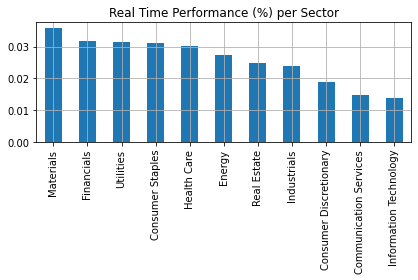

In [5]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [6]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [7]:
r = requests.get(url)
output = r.json()

In [8]:
print(output["Global Quote"]["05. price"])

124.1800


In [9]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [10]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [11]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [12]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [13]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [14]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [15]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [16]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [17]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [18]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [19]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [20]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
135     DGRO
136     TD6C
137     TDG0
138    PTTRX
139      NaN
Name: Ticker, Length: 140, dtype: object

In [21]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [22]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
15-Feb - UP (43.6000)
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb - UP (203.5800)
16-Mar
04-Feb - UP (64.9900)
17-Feb - UP (55.6500)
27-Jan - UP (319.1700)
09-Feb - UP (8.8500)
14-Mar
09-Mar
17-Feb - UP (78.4600)
02-Mar
25-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
22-Feb - DN (124.0600)
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb - UP (80.9100)
17-Feb - DN (182.4200)
09-Feb - UP (205.9100)
09-Feb - UP (152.1600)
28-Feb
24-Feb - DN (221.8500)
16-Feb - DN (9.7000)
16-Feb - DN (746.8500)
26-Jan - UP (228.2200)
15-Feb - DN (89.0600)
24-Feb - DN (487.1800)
28-Feb
23-Feb - UP (13.4300)
08-Feb - UP (8.5800)
22-Feb - DN (61.4600)
15-Feb - UP (61.9700)
15-Feb - UP (11.8800)
28-Feb
08-Feb - UP (364.9400)
03-Feb - UP (138.1800)
08-Feb - UP (37.2700)
10-Feb - DN (51.3400)
08-Mar
28-Mar
07-Mar
24-Feb - UP (28.3500)
16-Feb - DN (12.7600)
21-Mar
08-Mar
02-Mar
23-Feb - UP (183.1900)
10-Feb - UP

In [23]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [24]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [25]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [26]:
status = is_currentQtr(7)
print(status)

False


In [27]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [28]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [113]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises", "Subscribers"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [30]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [31]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [32]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [33]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [34]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [35]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [36]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTALCURRENTASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [87]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FIRST QUARTER", "SECOND QUARTER", "THIRD QUARTER", "FOURTH QUARTER", "FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("\nHEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK", "GAAP QUARTERLY"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if (str(x) != "%" and str(x) != "%)") else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [38]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [39]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [88]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1794515/000179451520000016/zi-8kxex991x20200810.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1            Q2 2020 Financial Highlights (Unaudited)   
2           ($ in millions, except per share amounts)   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                             Revenue   
7                                                 NaN   
8                                   Operating Loss(1)   
9                                                 NaN   
10                                   Operating Margin   
11                                                NaN   
12                       Net Loss Per Share (Diluted)   
13                                                NaN   
14                Cash Flow from Operating Activities   
15  (1) Q2 2020


FINAL REPORT
                                      METRIC              Q3 2020  \
2                               GAAP REVENUE  $116 - $118 million   
3         NON-GAAP ADJUSTED OPERATING INCOME    $53 - $55 million   
4  NON-GAAP ADJUSTED OPERATING INCOME MARGIN                  46%   
5     NON-GAAP ADJUSTED NET INCOME PER SHARE        $0.08 - $0.09   
6          NON-GAAP UNLEVERED FREE CASH FLOW           Not Guided   
7        WEIGHTED AVERAGE SHARES OUTSTANDING          403 million   

               FY 2020  
2  $451 - $455 million  
3  $213 - $217 million  
4                  47%  
5        $0.29 - $0.30  
6  $206 - $210 million  
7          403 million  

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                          ZoomInfo Technologies Inc.   
2               Condensed Consolidated Balance Sheets   
3                    (in millions, except shar

HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
8                                             REVENUE   
10                                    COST OF SERVICE   
11                                    COST OF SERVICE   
12                AMORTIZATION OF ACQUIRED TECHNOLOGY   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
20     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
21                           TOTAL OPERATING EXPENSES   
22                      INCOME (LOSS) FROM OPERATIONS   
24                              INTEREST EXPENSE, NET   
25     

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
10                                  NET INCOME (LOSS)   
11      OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
12         UNREALIZED GAIN (LOSS) ON CASH FLOW HEDGES   
13  REALIZED LOSS (GAIN) ON SETTLEMENT OF CASH FLO...   
14  AMORTIZATION OF DEFERRED LOSSES RELATED TO THE...   
15                  OTHER COMPREHENSIVE INCOME (LOSS)   
16                        COMPREHENSIVE INCOME (LOSS)   
17  LESS NET INCOME ATTRIBUTABLE TO ZOOMINFO OPCO ...   
18  LESS COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE ...   
19  COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE TO ZO...   

   NAN THREE MONTHS ENDED JUNE 30, 2020 NAN THREE MONTHS ENDED JUNE 30, 2019  \
10                              $(56.2)                              $(19.9)   
11                                  nan                                  nan   
12                

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
8                           CASH FLOW FROM OPERATIONS   
9   PURCHASES OF PROPERTY AND EQUIPMENT AND OTHER ...   
10                              INTEREST PAID IN CASH   
11  RESTRUCTURING AND TRANSACTION-RELATED EXPENSES...   
12  INTEGRATION COSTS AND ACQUISITION-RELATED COMP...   
13                           UNLEVERED FREE CASH FLOW   

   NAN THREE MONTHS ENDED JUNE 30, 2020 NAN THREE MONTHS ENDED JUNE 30, 2019  \
8                                 $25.3                               $(5.3)   
9                                 (4.1)                                (3.4)   
10                                 23.8                                 42.1   
11                                  5.3                                  0.9   
12                                  1.9                                  4.3   
13    

HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
7                                   NET INCOME (LOSS)   
8                           BENEFIT FROM INCOME TAXES   
9                               INTEREST EXPENSE, NET   
10                        LOSS ON DEBT EXTINGUISHMENT   
11                        OTHER (INCOME) EXPENSE, NET   
12                      INCOME (LOSS) FROM OPERATIONS   
13  IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIRED U...   
14                AMORTIZATION OF ACQUIRED TECHNOLOGY   
15         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
16                  EQUITY-BASED COMPENSATION EXPENSE   
17     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
18  INTEGRATION COSTS AND ACQUISITION-RELATED EXPE...   
19                          ADJUSTED OPERATING INCOME   
20                          BENEFIT FROM INCOME TAXES   
21    T

FINAL REPORT
                                              METRIC  \
3                          ADJUSTED OPERATING INCOME   
5                                            REVENUE   
6  IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIRED U...   
7  REVENUE FOR ADJUSTED OPERATING MARGIN CALCULATION   
8                   ADJUSTED OPERATING INCOME MARGIN   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
3                            $55.0                            $41.3   
5                            110.9                             68.5   
6                              0.3                             10.7   
7                           $111.2                            $79.2   
8                              49%                              52%   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2019  
3                         $104.0                          $72.9  
5                          213.1                          123.1  
6                        

In [40]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [41]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [42]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [43]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [44]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [116]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning report for stock NIO on date 2022-02-28 does not exist, trying to fetch it
Earning report for stock NIO fetching status False, filename None
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Quote for stock ENB on earning date 15-Feb - UP (43.6000) already generated
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Quote for stock KNSL on earning date 17-Feb - UP (203.5800) already generated
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Quote for stock APPN on earning date 17-Feb - UP (55.6500) already generated
Quote for stock TEAM on earning date 27-Jan - UP (319.1700

Earning report for stock CRM fetching status False, filename None
Quote for stock CRM on earning date 27-Feb not generated yet
Quote for stock BABA on earning date 24-Feb - DN (108.9300) already generated
Quote for stock CFLT on earning date 10-Feb - DN (57.1800) already generated
Earning report for stock PLUG on date 2022-02-27 does not exist, trying to fetch it
Earning report for stock PLUG fetching status False, filename None
Quote for stock PLUG on earning date 27-Feb not generated yet
Quote for stock ZNGA on earning date 09-Feb - NC (9.1700) already generated
Earning for stock LULU will be released later on 2022-03-28
Quote for stock LULU on earning date 28-Mar not generated yet
Quote for stock NET on earning date 10-Feb - DN (104.9200) already generated
Earning report for stock BILI on date 2022-02-27 does not exist, trying to fetch it
Earning report for stock BILI fetching status False, filename None
Quote for stock BILI on earning date 27-Feb not generated yet
Quote for stock I

In [108]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [110]:
stocks = get_earningDates(d, "WK")
print(stocks, "\n", len(stocks))

[['NIO', '28-Feb-2022'], ['FLGT', '02-Mar-2022'], ['ZM', '28-Feb-2022'], ['MELI', '28-Feb-2022'], ['LMND', '28-Feb-2022'], ['OPEN', '02-Mar-2022'], ['SNOW', '01-Mar-2022'], ['NNOX', '28-Feb-2022'], ['DPZ', '01-Mar-2022'], ['OKTA', '01-Mar-2022'], ['FUBO', '28-Feb-2022']] 
 11


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [47]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [48]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [49]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [50]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [53]:
import json
org = "CRWD"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/CRWD/profile?p=CRWD
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-transactions?p=CRWD
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-roster?p=CRWD
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/holders?p=CRWD
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 1.46%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 72.06%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 73.13%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 1394
https://finance.yahoo.com/quote/CRWD/analysis?p=CRWD
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 1/30/2021 1 1 0.13
Table Number 2
FOUND
2 4/29/2021 1 2 0.1
Table Number 2
FOUND
3 7/30/2021 1 3 0.11
Table Number 2
FOUND
4 10/30/2021 1 4 0.17
Table Number 2
FOUND
1 1/30/2021 0 1 0.08
Table Number 2
FOUND
2 4/29/2021 0 2 0.06
Tab

In [80]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/0001713683/000171368322000025/zs-01312022_991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

11


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [51]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [52]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [53]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [54]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [55]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [56]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [57]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [58]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [59]:
def isBold(tag, ctext):
    listag = ["ul", "li"]
    if((tag.name == "b" and tag.parent.name not in listag) or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [60]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tags), ctag.name, ctag.text, tags)
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.name == "u"):
                continue
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [61]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [62]:
def isPadLeft(item):
    if(item.name == "ul" or item.name == "li"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [63]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [64]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    listag = ["ul", "li"]
    if not txt:
        if(item.name in listag):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", " ")
    ctext = ctext.replace("     ", " ")
    ctext = ctext.replace("    ", " ")
    ctext = ctext.replace("   ", " ")
    ctext = ctext.replace("  ", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name not in listag and item.parent.name not in listag):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [65]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [66]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle+" .")
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk]+" .")
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata+" .")
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr+" .")
    f.write("\n")
    return possibleTblTitle

In [67]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            eyr = eyr + emonth
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    hc = False #Header continue to next row
    dollarCol = list()
    f.write("\n")
    f.write(tblStr+" .")
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            hc = False
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    if "MARGIN" in newcol.upper() and "%" not in content:
                        content = content + "%"
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
                hc = True
            else:
                if hc:
                    header = header + " " + met
                else:
                    header = met
        elif(met == "TOTAL"):
            header = None
        else:
            hc = False
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr+" .")
    f.write("\n")

In [68]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br", "li"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul" and len(tag.findChildren("li", recursive=True)) == 0):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "li" and len(tag.findChildren("li", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [106]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2019-03-13"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [103]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1441816/000144181619000044/mdb-013119xex991xrelease.htm"
source = getPgSource(url)

In [104]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 46

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER FISCAL  2019  FINANCIAL HIGHLIGHTS UNDER ASC 606
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $85.5 million in th...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $85.5 MILLION  IN THE  FOURTH  QUARTER FISCAL  2019 , AN INCREASE OF  71%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $80.6 MILLION , AN INCREASE OF  73%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS  $4.9 MILLION , AN INCREASE OF  37%  YEAR-OVER-YEAR.
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    •  Gross Profit: Gross profit was $59.9 million i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  • GROSS PROFIT:  GROSS PROFIT WAS  $59.9 MILLION 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION:  • AMORTIZATION OF THE FOUNDER HOLDBACK ASSOCIATED WITH THE MLAB PURCHASE, THAT WAS DEEMED TO BE COMPENSATION EXPENSE FOR GAAP PURPOSES;
ORIGINAL TABLE  26
     0                                                  1
0  NaN                                                NaN
1    •  acquisition costs associated with the purchase...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION:  • ACQUISITION COSTS ASSOCIATED WITH THE PURCHASE OF MLAB;
ORIGINAL TABLE  27
     0                                                  1
0  NaN                                                NaN
1    •  accelerated charges associated with the New Yo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION:  • ACCELERATED CHARGES ASSOCIATED WITH THE NEW YORK CITY OFFICE MOVE; AND
ORIGINAL TABLE  28
     0                                                  1
0  NaN      

HEADERSSSSSSSSS ['0:1', '25:26']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERA

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10        NON-CASH INTEREST ON OFFICE FINANCING LEASE   
11                              DEFERRED INCOME TAXES   
12          CHANGE IN FAIR VALUE OF WARRANT LIABILITY   
13         CHANGE IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                               DEFERRED COMMISSIONS   
17                             OTHER LONG-TERM ASSETS   
18                                   ACCOUNTS PAYABLE   
1

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31], 33: [34, 35], 37: [38, 39], 41: [42, 43], 45: [46, 47], 48: [49, 50], 52: [53, 54], 56: [57, 58]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16               

                                            0   \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                       Assets   
4                              Current assets:   
5                    Cash and cash equivalents   
6                       Short-term investments   
7                     Accounts receivable, net   
8                         Deferred commissions   
9    Prepaid expenses and other current assets   
10                        Total current assets   
11                 Property and equipment, net   
12                                    Goodwill   
13             Acquired intangible assets, net   
14                         Deferred tax assets   
15                                Other assets   
16                                Total assets   
17        Liabilities and Stockholders’ Equity   
18                        Current liabilities:   


{1: [2, 3], 4: [5, 6], 7: [8, 9], 10: [11, 12], 13: [14, 15], 16: [17, 18], 19: [20, 21], 22: [23, 24], 25: [26, 27], 28: [29, 30], 31: [32, 33], 34: [35, 36]}

FINAL REPORT
                                       METRIC  \
3                                      ASSETS   
4                              CURRENT ASSETS   
5                   CASH AND CASH EQUIVALENTS   
6                      SHORT-TERM INVESTMENTS   
7                    ACCOUNTS RECEIVABLE, NET   
8                        DEFERRED COMMISSIONS   
9   PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                       TOTAL CURRENT ASSETS   
11                PROPERTY AND EQUIPMENT, NET   
12                                   GOODWILL   
13            ACQUIRED INTANGIBLE ASSETS, NET   
14                        DEFERRED TAX ASSETS   
15                               OTHER ASSETS   
16                               TOTAL ASSETS   
17        LIABILITIES AND STOCKHOLDERS EQUITY   
18                        CURRENT LIABILIT

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                       

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDED JANUARY 31, 2019  \
4            COST OF REVENUESUBSCRIPTION                                $644   
5                COST OF REVENUESERVICES                                 439   
6                    SALES AND MARKETING                                3620   
7               RESEARCH AND DEVELOPMENT                                3446   
8             GENERAL AND ADMINISTRATIVE                                2404   
9  TOTAL STOCKBASED COMPENSATION EXPENSE                              $10553   

  THREE MONTHS ENDED OCTOBER 31, 2018 THREE MONTHS ENDED JULY 31, 2018  \
4                                $555                             $489   
5                                 335                              281   
6                                3090                             2129   
7                      

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP GROSS PROFIT TO NON-GAA...   
5                        GROSS PROFIT ON A GAAP BASIS   
6   GROSS MARGIN (GROSS PROFIT/TOTAL REVENUE) ON A...   
7                                            ADD BACK   
8   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
9   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
10                              NON-GAAP GROSS PROFIT   
11  NON-GAAP GROSS MARGIN (NON-GAAP GROSS PROFIT/T...   
13  RECONCILIATION OF GAAP LOSS FROM OPERATIONS TO...   
14               LOSS FROM OPERATIONS ON A GAAP BASIS   
15                                           ADD BACK   
16                   STOCK-BASED COMPENSATION EXPENSE   
17  AMORTIZATION OF INTANGIBLE ASSETS AND FOUNDER ...   
18                                  ACQUISITION COSTS   
19  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
2

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDED JANUARY 31, 2019  \
4  NET CASH USED IN OPERATING ACTIVITIES                              $(9480   
5                   CAPITAL EXPENDITURES                               (3150   
6                   CAPITALIZED SOFTWARE                                 nan   
7                         FREE CASH FLOW                             $(12630   

  THREE MONTHS ENDED JANUARY 31, 2018 YEAR ENDED JANUARY 31, 2019  \
4                              $(7712                     $(41989   
5                                (421                       (6848   
6                                 nan                         nan   
7                              $(8133                     $(48837   

  YEAR ENDED JANUARY 31, 2018  
4                     $(44881  
5                       (2135  
6                         nan  
7                     $(47016  

FOR T

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP NET LOSS PER SHARE, BAS...   
5   NET LOSS PER SHARE, BASIC AND DILUTED, ON A GA...   
6                                            ADD BACK   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
9                                   ACQUISITION COSTS   
10  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
11  NON-CASH INTEREST EXPENSE RELATED TO CONVERTIB...   
12          CHANGE IN FAIR VALUE OF WARRANT LIABILITY   
13  NON-RECURRING INCOME TAX BENEFIT ASSOCIATED WI...   
14  IMPACT OF ADDITIONAL WEIGHTED-AVERAGE SHARES G...   
15     NON-GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
17  RECONCILIATION OF GAAP WEIGHTED-AVERAGE SHARES...   
18  WEIGHTED-AVERAGE SHARES USED TO COMPUTE NET LO...   
19                                           ADD BACK   
2

In [105]:
allTables

{'TOTAL': 46,
 'PARSESUCCESS': [22, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41, 43, 44, 45],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  32,
  36,
  37,
  42],
 0: {'ORIGINAL': '[{"0":null,"1":null},{"0":null,"1":"Revenue: Total revenue was $85.5 million in the fourth quarter fiscal 2019, an increase of 71% year-over-year. Subscription revenue was $80.6 million, an increase of 73% year-over-year, and services revenue was $4.9 million, an increase of 37% year-over-year."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null},{"0":null,"1":"Gross Profit: Gross profit was $59.9 million in the fourth quarter fiscal 2019, representing a 70% gross margin, compared to 75% year-ago period. Non-GAAP gross profit was $61.0 million, representing a 71% non-GAAP gross margin."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":null},{"0":null,"1":"Loss from Operations: Loss from operations was $23.8

In [107]:
csym = "MDB"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/ZI_2022-02-15_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
testOne8KEdgarRpt(url, csym, None, source, allTables)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/MDB'
NOPAD*** Exhibit.

NOPAD*** Exhibit 99.1.


SC*** MongoDB, Inc. Announces Fourth Quarter and Full Year Fiscal 2019 Financial Results.


SC*** ASC 606:.


SC*** Fourth Quarter Fiscal 2019 Total Revenue of $85.5 million, up 71% Year-over-Year.


SC*** Full Year Fiscal 2019 Total Revenue of $267.0 million, up 61% Year-over-Year.


SC*** MongoDB Atlas Revenue 32% of Total Q4 Revenue, up over 400% Year-over-Year.


SC*** ASC 605:.


SC*** Fourth Quarter Fiscal 2019 Total Revenue of $83.1 million, up 85% Year-over-Year.


SC*** Full Year Fiscal 2019 Total Revenue of $253.8 million, up 64% Year-over-Year.


SC*** MongoDB Atlas Revenue 34% of Total Q4 Revenue, up over 400% Year-over-Year.


SC*** Note: We recently adopted the new revenue recognition accounting standard Accounting Standards Codification ("ASC") 606 effective as of January 31, 2019 and applied as of February 1, 2018, on a full retros

In [117]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [118]:
csym = "MDB"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/MDB'
1441816
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000044-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181619000044/mdb-013119xex991xrelease.htm
NUMBER OF TABLES 46

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER FISCAL  2019  FINANCIAL HIGHLIGHTS UNDER ASC 606
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $85.5 million in th...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $85.5 MILLION  IN THE  FOURTH  QUARTER FISCAL  2019 , AN INCREASE OF  71%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $80.6 MILLION , AN INCREASE OF  73%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS  $4.9 MILLION , AN INCREASE OF  37%  YEAR-OVER-YEAR.
ORIGINAL TABLE  1
     0     

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC AS OF JANUARY 31, 2019  \
4                                              ASSETS                    nan   
5                                      CURRENT ASSETS                    nan   
6                           CASH AND CASH EQUIVALENTS                $147831   
7                              SHORT-TERM INVESTMENTS                 318139   
8   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...                  64833   
9                                DEFERRED COMMISSIONS                  15878   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS                  19555   
11                               TOTAL CURRENT ASSETS                 566236   
12                        PROPERTY AND EQUIPMENT, NET                  73664   
13                                           GOODWILL                  41878   
14                    ACQUIRED INTANGIBLE ASSETS, NET                  15894   
15 

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10        NON-CASH INTEREST ON OFFICE FINANCING LEASE   
11                              DEFERRED INCOME TAXES   
12          CHANGE IN FAIR VALUE OF WARRANT LIABILITY   
13         CHANGE IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                               DEFERRED COMMISSIONS   
17                             OTHER LONG-TERM ASSETS   
18                                   ACCOUNTS PAYABLE   
1

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31], 33: [34, 35], 37: [38, 39], 41: [42, 43], 45: [46, 47], 48: [49, 50], 52: [53, 54], 56: [57, 58]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND AD

{1: [2, 3], 4: [5, 6], 7: [8, 9], 10: [11, 12], 13: [14, 15], 16: [17, 18], 19: [20, 21], 22: [23, 24], 25: [26, 27], 28: [29, 30], 31: [32, 33], 34: [35, 36]}

FINAL REPORT
                                       METRIC  \
3                                      ASSETS   
4                              CURRENT ASSETS   
5                   CASH AND CASH EQUIVALENTS   
6                      SHORT-TERM INVESTMENTS   
7                    ACCOUNTS RECEIVABLE, NET   
8                        DEFERRED COMMISSIONS   
9   PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                       TOTAL CURRENT ASSETS   
11                PROPERTY AND EQUIPMENT, NET   
12                                   GOODWILL   
13            ACQUIRED INTANGIBLE ASSETS, NET   
14                        DEFERRED TAX ASSETS   
15                               OTHER ASSETS   
16                               TOTAL ASSETS   
17        LIABILITIES AND STOCKHOLDERS EQUITY   
18                        CURRENT LIABILIT

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION:  *  PRIOR PERIOD INFORMATION HAS BEEN ADJUSTED TO REFLECT THE ADOPTION OF THE NEW REVENUE STANDARD, WHICH MONGODB ADOPTED ON JANUARY 31, 2019 AND APPLIED RETROSPECTIVELY AS OF FEBRUARY 1, 2018.
ORIGINAL TABLE  38
                                       0                   1   \
0                                     NaN                 NaN   
1                                     NaN                 NaN   
2                                     NaN  Three Months Ended   
3                                     NaN    January 31, 2019   
4            Cost of revenue—subscription                   $   
5                Cost of revenue—services                 439   
6                     Sales and marketing                3620   
7                Research and development                3446   
8              General and administrative                2404   
9  Total stock‑based compensation expense           


FINAL REPORT
                          METRIC JANUARY 31, 2019 OCTOBER 31, 2018AS ADJUSTED  \
3               DEFERRED REVENUE          $122333                      $98129   
4  DEFERRED REVENUE, NON-CURRENT            15343                       13843   

  JULY 31, 2018AS ADJUSTED APRIL 30, 2018AS ADJUSTED  \
3                   $92091                    $87542   
4                    14676                     16164   

  JANUARY 31, 2018AS ADJUSTED OCTOBER 31, 2017AS ADJUSTED  \
3                      $84415                      $69393   
4                       16499                       15122   

  JULY 31, 2017AS ADJUSTED APRIL 30, 2017AS ADJUSTED  
3                   $63882                    $59456  
4                    11805                      9422  

FOR TABLE 40

TABLE DESCRIPTION: 
ORIGINAL TABLE  40
                                                   0   \
0                                                 NaN   
1                                                 NaN   

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP NET LOSS PER SHARE, BAS...   
5   NET LOSS PER SHARE, BASIC AND DILUTED, ON A GA...   
6                                            ADD BACK   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
9                                   ACQUISITION COSTS   
10  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
11  NON-CASH INTEREST EXPENSE RELATED TO CONVERTIB...   
12          CHANGE IN FAIR VALUE OF WARRANT LIABILITY   
13  NON-RECURRING INCOME TAX BENEFIT ASSOCIATED WI...   
14  IMPACT OF ADDITIONAL WEIGHTED-AVERAGE SHARES G...   
15     NON-GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
17  RECONCILIATION OF GAAP WEIGHTED-AVERAGE SHARES...   
18  WEIGHTED-AVERAGE SHARES USED TO COMPUTE NET LO...   
19                                           ADD BACK   
20  ADDITIONAL WEIGHTED-AVERAGE SHARES GIVING EFFE...   
21  NON-GAAP WEIGH

21                    43213082                         NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP NET LOSS PER SHARE, BAS...   
5   NET LOSS PER SHARE, BASIC AND DILUTED, ON A GA...   
6                                            ADD BACK   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
9                                   ACQUISITION COSTS   
10  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
11  NON-CASH INTEREST EXPENSE RELATED TO CONVERTIB...   
12          CHANGE IN FAIR VALUE OF WARRANT LIABILITY   
13  NON-RECURRING INCOME TAX BENEFIT ASSOCIATED WI...   
14  IMPACT OF ADDITIONAL WEIGHTED-AVERAGE SHARES G...   
15     NON-GAAP NET LOSS PER SHARE, BASIC AND DILUTED   
17  RECONCILIATION OF GAAP WEIGHTED-AVERAGE SHARES...   
18  WEIGHTED-AVERAGE SHARES USED TO COMPUTE NET LO... 

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000107-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181619000107/mdb-43019xex991xrelease.htm
NUMBER OF TABLES 22

FOR TABLE 0

TABLE DESCRIPTION:  FIRST  QUARTER FISCAL  2020  FINANCIAL HIGHLIGHTS
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $89.4 million in th...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $89.4 MILLION  IN THE  FIRST  QUARTER FISCAL  2020 , AN INCREASE OF  78%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $84.0 MILLION , AN INCREASE OF  82%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS  $5.4 MILLION , AN INCREASE OF  33%  YEAR-OVER-YEAR.
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    •  Gross Pr

9                             $7577  

FOR TABLE 18

TABLE DESCRIPTION: 
ORIGINAL TABLE  18
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                Cash flows from operating activities   
5                                            Net loss   
6   Adjustments to reconcile net loss to net cash ...   
7                       Depreciation and amortization   
8                            Stock-based compensation   
9    Amortization of debt discount and issuance costs   
10        Amortization of finance right-of-use assets   
11     Non-cash interest on finance lease liabilities   
12                              Deferred income taxes   
13    Accretion of discount on short-term investments   
14        Change in operating assets and liabilities:

7                             $2825                            $(8416  

FOR TABLE 21

TABLE DESCRIPTION: 
ORIGINAL TABLE  21
                          0          1      2          3      4           5   \
0                        NaN        NaN    NaN        NaN    NaN         NaN   
1                        NaN        NaN    NaN        NaN    NaN         NaN   
2                        NaN      As of  As of      As of  As of       As of   
3                        NaN  4/30/2017    NaN  7/31/2017    NaN  10/31/2017   
4            Total Customers     3,700+    NaN     4,300+    NaN      4,900+   
5  Direct Sales Customers(a)     1,300+    NaN     1,350+    NaN      1,400+   
6    MongoDB Atlas Customers     1,300+    NaN     1,900+    NaN      2,600+   
7    Customers over $100K(b)        268    NaN        296    NaN         320   

      6          7      8          9      10         11     12          13  \
0    NaN        NaN    NaN        NaN    NaN        NaN    NaN         NaN 

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000147-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000147-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000179-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181619000179/mdb-73119xex991xrelease.htm
NUMBER OF TABLES 22

FOR TABLE 0

TABLE DESCRIPTION:  SECOND  QUARTER FISCAL  2020  FINANCIAL HIGHLIGHTS
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $99.4 million in th...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $99.4 MILLION  IN THE  SECOND  QUARTER FISCAL  2020 , AN INCREASE OF  67%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $94.2 MILLION , AN INCREASE OF  71%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS 

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDED JULY 31, 2019  \
4            COST OF REVENUESUBSCRIPTION                            $1214   
5                COST OF REVENUESERVICES                              721   
6                    SALES AND MARKETING                             5944   
7               RESEARCH AND DEVELOPMENT                             6114   
8             GENERAL AND ADMINISTRATIVE                             3669   
9  TOTAL STOCKBASED COMPENSATION EXPENSE                           $17662   

  THREE MONTHS ENDED JULY 31, 2018 SIX MONTHS ENDED JULY 31, 2019  \
4                             $489                          $2202   
5                              281                           1314   
6                             2129                          10884   
7                             2904                          10634   
8                             3206                  

7    NaN        598    NaN        622  
HEADERSSSSSSSSS ['0:1']
{}

FINAL REPORT
                      METRIC AS OF 7/31/2017 AS OF 10/31/2017 AS OF 1/31/2018  \
4            TOTAL CUSTOMERS           4300+            4900+           5700+   
5  DIRECT SALES CUSTOMERS(A)           1350+            1400+           1450+   
6    MONGODB ATLAS CUSTOMERS           1900+            2600+           3400+   
7       CUSTOMERS OVER $K(B)             296              320             354   

  AS OF 4/30/2018 AS OF 7/31/2018 AS OF 10/31/2018 AS OF 1/31/2019  \
4           6600+           7400+            8300+          13400+   
5           1550+           1600+            1700+           1750+   
6           4400+           5300+            6200+          11400+   
7             394             438              490             557   

  AS OF 4/30/2019 AS OF 7/31/2019  
4          14200+          15000+  
5           1800+           1850+  
6          12300+          13200+  
7             598 

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000221-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000221-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-19-000239-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181619000239/mdb-103119xex991xrelea.htm
NUMBER OF TABLES 23

FOR TABLE 0

TABLE DESCRIPTION:  THIRD  QUARTER FISCAL  2020  FINANCIAL HIGHLIGHTS 
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $109.4 million in t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $109.4 MILLION  IN THE  THIRD  QUARTER FISCAL  2020 , AN INCREASE OF  52%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $103.8 MILLION , AN INCREASE OF  56%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS 

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERATIONS   
19                       

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10        AMORTIZATION OF FINANCE RIGHT-OF-USE ASSETS   
11      AMORTIZATION OF OPERATING RIGHT-OF-USE ASSETS   
12     NON-CASH INTEREST ON FINANCE LEASE LIABILITIES   
13                              DEFERRED INCOME TAXES   
14    ACCRETION OF DISCOUNT ON SHORT-TERM INVESTMENTS   
15         CHANGE IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                               DEFERRED COMMISSIONS   
19                             OTHER LONG-TERM ASSETS   
20                

HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                      METRIC 10/31/2017 1/31/2018 4/30/2018 7/31/2018  \
4            TOTAL CUSTOMERS      4900+     5700+     6600+     7400+   
5  DIRECT SALES CUSTOMERS(A)      1400+     1450+     1550+     1600+   
6    MONGODB ATLAS CUSTOMERS      2600+     3400+     4400+     5300+   
7       CUSTOMERS OVER $K(B)        320       354       394       438   

  10/31/2018 1/31/2019 4/30/2019 7/31/2019 10/31/2019  
4      8300+    13400+    14200+    15000+     15900+  
5      1700+     1750+     1800+     1850+      1900+  
6      6200+    11400+    12300+    13200+     14200+  
7        490       557       598       622        688  
EARNING REPORT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/000144181619000239/mdb-103119xex991xrelea.htm, STORING REPORT...
NOPAD*** Exhibit.

NOPAD*** Exhibit 99.1.


SC*** MongoDB, Inc. Announces Third Quarter Fiscal 2020 Financial Results.


SC*** Third Quarter Fiscal 2020 Total Revenue of 

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001104659-20-003938-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000110465920003938/tm201523d2_ex99-1.htm
NUMBER OF TABLES 27

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
     0                         1
0  c/o  Morgan Stanley & Co. LLC
1  NaN             1585 Broadway
2  NaN  New York, New York 10036
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
     0                         1
0  c/o   Goldman Sachs & Co. LLC
1  NaN           200 West Street
2  NaN  New York, New York 10282
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
     0                         1
0  c/o     Barclays Capital Inc.
1  NaN        745 Seventh Avenue
2  NaN  New York, New York 10019
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:   
ORIGINAL TABLE  3
     0                        

EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000027/exhibit991markporterpres.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/000144181620000027/exhibit991markporterpres.htm
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000062-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000062/mdb-013120xex991xrelea.htm
NUMBER OF TABLES 29

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER FISCAL  2020  FINANCIAL HIGHLIGHTS 
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $123.5 million in t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $123.5 MILLION  IN THE  FOURTH  QUARTER FISCAL  2020 , AN INCREASE OF  44%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $117.8 MILLION , AN INCREASE OF  46%  YEAR-O


FINAL REPORT
                                               METRIC AS OF JANUARY 31, 2020  \
4                                              ASSETS                    nan   
5                                      CURRENT ASSETS                    nan   
6                           CASH AND CASH EQUIVALENTS                $706192   
7                              SHORT-TERM INVESTMENTS                 280326   
8   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...                  85554   
9                                DEFERRED COMMISSIONS                  24219   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS                  16905   
11                               TOTAL CURRENT ASSETS                1113196   
12                        PROPERTY AND EQUIPMENT, NET                  58316   
13                OPERATING LEASE RIGHT-OF-USE ASSETS                  11147   
14                                           GOODWILL                  55830   
15                    ACQU

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10        AMORTIZATION OF FINANCE RIGHT-OF-USE ASSETS   
11      AMORTIZATION OF OPERATING RIGHT-OF-USE ASSETS   
12        NON-CASH INTEREST ON OFFICE FINANCING LEASE   
13                              DEFERRED INCOME TAXES   
14    ACCRETION OF DISCOUNT ON SHORT-TERM INVESTMENTS   
15               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
16         CHANGE IN OPERATING ASSETS AND LIABILITIES   
17                                ACCOUNTS RECEIVABLE   
18          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
1

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
5                            NET LOSS ON A GAAP BASIS   
6                                            ADD BACK   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   AMORTIZATION OF INTANGIBLE ASSETS AND TIME-BAS...   
9                                   ACQUISITION COSTS   
10  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
11  NON-CASH INTEREST EXPENSE RELATED TO CONVERTIB...   
12  NON-RECURRING LOSS FROM THE EARLY EXTINGUISHME...   
13  NON-RECURRING INCOME TAX BENEFIT ASSOCIATED WI...   
14                                  NON-GAAP NET LOSS   
16  RECONCILIATION OF GAAP NET LOSS PER SHARE, BAS...   
17  NET LOSS PER SHARE, BASIC AND DILUTED, ON A GA...   
18                                           ADD BACK   
19                   STOCK-BASED COMPENSATION EXPENSE   
20  AMORTIZATION OF INTAN

[36 rows x 32 columns]
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP LOSS FROM OPERATIONS TO...   
5                LOSS FROM OPERATIONS ON A GAAP BASIS   
6                                            ADD BACK   
7                    STOCK-BASED COMPENSATION EXPENSE   
8   AMORTIZATION OF INTANGIBLE ASSETS AND FOUNDER ...   
9                                   ACQUISITION COSTS   
10  ACCELERATED CHARGES ASSOCIATED WITH THE NEW YO...   
11                      NON-GAAP LOSS FROM OPERATIONS   
13  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
14                           NET LOSS ON A GAAP BASIS   
15                                           ADD BACK   
16                   STOCK-BASED COMPENSATION EXPENSE   
17  AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
18                                 

{}

FINAL REPORT
                      METRIC 1/31/2018 4/30/2018 7/31/2018 10/31/2018  \
4            TOTAL CUSTOMERS     5700+     6600+     7400+      8300+   
5  DIRECT SALES CUSTOMERS(A)     1450+     1550+     1600+      1700+   
6    MONGODB ATLAS CUSTOMERS     3400+     4400+     5300+      6200+   
7       CUSTOMERS OVER $K(B)       354       394       438        490   

  1/31/2019 4/30/2019 7/31/2019 10/31/2019 1/31/2020  
4    13400+    14200+    15000+     15900+    17000+  
5     1750+     1800+     1850+      1900+     2000+  
6    11400+    12300+    13200+     14200+    15400+  
7       557       598       622        688       751  
EARNING REPORT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/000144181620000062/mdb-013120xex991xrelea.htm, STORING REPORT...
NOPAD*** Exhibit.

NOPAD*** Exhibit 99.1.


SC*** MongoDB, Inc. Announces Fourth Quarter and Full Year Fiscal 2020 Financial Results.


SC*** Fourth Quarter Fiscal 2020 Total Revenue of $123.5 millio

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000107-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000107/mdb-43020xex991xrelease.htm
NUMBER OF TABLES 24

FOR TABLE 0

TABLE DESCRIPTION:  FIRST  QUARTER FISCAL  2021  FINANCIAL HIGHLIGHTS 
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    •  Revenue: Total revenue was $130.3 million in t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  • REVENUE:  TOTAL REVENUE WAS  $130.3 MILLION  IN THE  FIRST  QUARTER FISCAL  2021 , AN INCREASE OF  46%  YEAR-OVER-YEAR. SUBSCRIPTION REVENUE WAS  $124.9 MILLION , AN INCREASE OF  49%  YEAR-OVER-YEAR, AND SERVICES REVENUE WAS  $5.5 MILLION , AN INCREASE OF  1%  YEAR-OVER-YEAR. 
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    •  Gross

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
10        AMORTIZATION OF FINANCE RIGHT-OF-USE ASSETS   
11      AMORTIZATION OF OPERATING RIGHT-OF-USE ASSETS   
12     NON-CASH INTEREST ON FINANCE LEASE LIABILITIES   
13                              DEFERRED INCOME TAXES   
14    ACCRETION OF DISCOUNT ON SHORT-TERM INVESTMENTS   
15         CHANGE IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNTS RECEIVABLE   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                               DEFERRED COMMISSIONS   
19                         

{}

FINAL REPORT
                      METRIC 4/30/2018 7/31/2018 10/31/2018 1/31/2019  \
4            TOTAL CUSTOMERS     6600+     7400+      8300+    13400+   
5  DIRECT SALES CUSTOMERS(A)     1550+     1600+      1700+     1750+   
6    MONGODB ATLAS CUSTOMERS     4400+     5300+      6200+    11400+   
7       CUSTOMERS OVER $K(B)       394       438        490       557   

  4/30/2019 7/31/2019 10/31/2019 1/31/2020 4/30/2020  
4    14200+    15000+     15900+    17000+    18400+  
5     1800+     1850+      1900+     2000+     2200+  
6    12300+    13200+     14200+    15400+    16800+  
7       598       622        688       751       780  

FOR TABLE 23

TABLE DESCRIPTION: 
ORIGINAL TABLE  23
                                                  0          1          2   \
0                                                NaN        NaN        NaN   
1                                                NaN        NaN        NaN   
2                                                NaN  

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000114-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000114-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000125-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000125/mdb062920finalmarkporter.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/000144181620000125/mdb062920finalmarkporter.htm
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000142-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000142-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000168-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000168/mdb-73120xex991xrelease.htm
NUMBER OF TABLES 24

FOR TABLE 0

TABLE DESCRIPTION:  SECOND  QUARTER FISCAL  2021  F

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        SUBSCRIPTION   
6                                            SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                        SUBSCRIPTION   
10                                           SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OPERATIONS   
19                       

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4   RECONCILIATION OF GAAP GROSS PROFIT TO NON-GAA...   
5                        GROSS PROFIT ON A GAAP BASIS   
6   GROSS MARGIN (GROSS PROFIT/TOTAL REVENUE) ON A...   
7                                            ADD BACK   
8   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
9   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
10                              NON-GAAP GROSS PROFIT   
11  NON-GAAP GROSS MARGIN (NON-GAAP GROSS PROFIT/T...   
13  RECONCILIATION OF GAAP OPERATING EXPENSES TO N...   
14  SALES AND MARKETING OPERATING EXPENSE ON A GAA...   
15                                               LESS   
16                   STOCK-BASED COMPENSATION EXPENSE   
17  AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
18     NON-GAAP SALES AND MARKETING OPERATING EXPENSE   
20  RESEARCH AND DEVELOPMENT OPERATING EXPENSE ON ...   
21                       

{}

FINAL REPORT
                      METRIC 7/31/2018 10/31/2018 1/31/2019 4/30/2019  \
4            TOTAL CUSTOMERS     7400+      8300+    13400+    14200+   
5  DIRECT SALES CUSTOMERS(A)     1600+      1700+     1750+     1800+   
6    MONGODB ATLAS CUSTOMERS     5300+      6200+    11400+    12300+   
7       CUSTOMERS OVER $K(B)       438        490       557       598   

  7/31/2019 10/31/2019 1/31/2020 4/30/2020 7/31/2020  
4    15000+     15900+    17000+    18400+    20200+  
5     1850+      1900+     2000+     2200+     2500+  
6    13200+     14200+    15400+    16800+    18800+  
7       622        688       751       780       819  

FOR TABLE 23

TABLE DESCRIPTION: 
ORIGINAL TABLE  23
                                                  0          1          2   \
0                                                NaN        NaN        NaN   
1                                                NaN        NaN        NaN   
2                                                NaN  

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-20-000226-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181620000226/mdb-103120xex991xrelea.htm
NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  BASED ON INFORMATION AS OF TODAY, DECEMBER 8, 2020, MONGODB IS ISSUING THE FOLLOWING FINANCIAL GUIDANCE FOR THE FOURTH QUARTER AND FULL YEAR FISCAL 2021.
ORIGINAL TABLE  0
                               0                              1  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                        Revenue                        Revenue   
3  Non-GAAP Loss from Operations  Non-GAAP Loss from Operations   
4    Non-GAAP Net Loss per Share    Non-GAAP Net Loss per Share   

                               2                                   3  \
0                            NaN                                 NaN   
1                            NaN     

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
2                                              ASSETS              nan   
3                                      CURRENT ASSETS              nan   
4                           CASH AND CASH EQUIVALENTS          $414762   
5                              SHORT-TERM INVESTMENTS           551539   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...            91784   
7                                DEFERRED COMMISSIONS            30090   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS            15611   
9                                TOTAL CURRENT ASSETS          1103786   
10                        PROPERTY AND EQUIPMENT, NET            63588   
11                OPERATING LEASE RIGHT-OF-USE ASSETS            36909   
12                                           GOODWILL            55830   
13                    ACQUIRED INTANGIBLE ASSETS, NET            28400   
14                       

FOR TABLE 4

TABLE DESCRIPTION:  (1)     INCLUDES STOCK‑BASED COMPENSATION EXPENSE AS FOLLOWS:
ORIGINAL TABLE  4
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                Cash flows from operating activities   
4                                            Net loss   
5   Adjustments to reconcile net loss to net cash ...   
6                       Depreciation and amortization   
7                            Stock-based compensation   
8    Amortization of debt discount and issuance costs   
9         Amortization of finance right-of-use assets   
10      Amortization of operating right-of-use assets   
11     Non-cash interest on finance lease liabilities   
12                              Deferred income taxes   
13    Accretion of discount on short-term investments   
14            Unrealized foreign

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP GROSS PROFIT TO NON-GAA...   
4                        GROSS PROFIT ON A GAAP BASIS   
5   GROSS MARGIN (GROSS PROFIT/TOTAL REVENUE) ON A...   
6                                            ADD BACK   
7   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
8   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
9                               NON-GAAP GROSS PROFIT   
10  NON-GAAP GROSS MARGIN (NON-GAAP GROSS PROFIT/T...   
12  RECONCILIATION OF GAAP OPERATING EXPENSES TO N...   
13  SALES AND MARKETING OPERATING EXPENSE ON A GAA...   
14                                               LESS   
15                   STOCK-BASED COMPENSATION EXPENSE   
16  AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
17     NON-GAAP SALES AND MARKETING OPERATING EXPENSE   
19  RESEARCH AND DEVELOPMENT OPERATING EXP


FINAL REPORT
                                              METRIC  \
3              NET CASH USED IN OPERATING ACTIVITIES   
4                               CAPITAL EXPENDITURES   
5  PRINCIPAL REPAYMENTS OF FINANCE LEASE LIABILITIES   
6                               CAPITALIZED SOFTWARE   
7                                     FREE CASH FLOW   

  THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
3                             $(8120)                            $(11543)   
4                              (5646)                               (754)   
5                              (1166)                               (798)   
6                                 nan                                 nan   
7                            $(14932)                            $(13095)   

  NINE MONTHS ENDED OCTOBER 31, 2020 NINE MONTHS ENDED OCTOBER 31, 2019  
3                           $(24028)                           $(20922)  
4                            (10942)  

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000046-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181621000046/mdb-013121xex991xrelease.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  BASED ON INFORMATION AS OF TODAY, MARCH 9, 2021, MONGODB IS ISSUING THE FOLLOWING FINANCIAL GUIDANCE FOR THE FIRST QUARTER AND FULL YEAR FISCAL 2022.
ORIGINAL TABLE  0
                               0                              1  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                        Revenue                        Revenue   
3  Non-GAAP Loss from Operations  Non-GAAP Loss from Operations   
4    Non-GAAP Net Loss per Share    Non-GAAP Net Loss per Share   

                               2                                   3  \
0                            NaN                                 NaN   
1                            NaN        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC AS OF JANUARY 31, 2021  \
3                                              ASSETS                    nan   
4                                      CURRENT ASSETS                    nan   
5                           CASH AND CASH EQUIVALENTS                $429697   
6                              SHORT-TERM INVESTMENTS                 528045   
7   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...                 135176   
8                                DEFERRED COMMISSIONS                  36619   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS                  12350   
10                               TOTAL CURRENT ASSETS                1141887   
11                        PROPERTY AND EQUIPMENT, NET                  62364   
12                OPERATING LEASE RIGHT-OF-USE ASSETS                  34587   
13                                           GOODWILL      

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9         AMORTIZATION OF FINANCE RIGHT-OF-USE ASSETS   
10      AMORTIZATION OF OPERATING RIGHT-OF-USE ASSETS   
11        NON-CASH INTEREST ON OFFICE FINANCING LEASE   
12                              DEFERRED INCOME TAXES   
13    ACCRETION OF DISCOUNT ON SHORT-TERM INVESTMENTS   
14               LOSS ON EARLY EXTINGUISHMENT OF DEBT   
15            UNREALIZED FOREIGN EXCHANGE (GAIN) LOSS   
16         CHANGE IN OPERATING ASSETS AND LIABILITIES   
17                

[22 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                            ADD BACK   
4                    STOCK-BASED COMPENSATION EXPENSE   
5   AMORTIZATION OF INTANGIBLE ASSETS AND TIME-BAS...   
6                                   ACQUISITION COSTS   
7   NON-CASH INTEREST EXPENSE RELATED TO CONVERTIB...   
8   NON-RECURRING LOSS FROM THE EARLY EXTINGUISHME...   
9   NON-RECURRING INCOME TAX BENEFIT ASSOCIATED WI...   
10                                  NON-GAAP NET LOSS   
12  RECONCILIATION OF GAAP NET LOSS PER SHARE, BAS...   
13  NET LOSS PER SHARE, BASIC AND DILUTED, ON A GA...   
14                                           ADD BACK   
15                   STOCK-BASED COMPENSATION EXPENSE   
16  AMORTIZATION OF INTANGIBLE ASSETS AND TIME-BAS...   
17                                  ACQUISITION COST

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                      METRIC 1/31/2019 4/30/2019 7/31/2019 10/31/2019  \
3            TOTAL CUSTOMERS    13400+    14200+    15000+     15900+   
4  DIRECT SALES CUSTOMERS(A)     1750+     1800+     1850+      1900+   
5    MONGODB ATLAS CUSTOMERS    11400+    12300+    13200+     14200+   
6       CUSTOMERS OVER $K(B)       557       598       622        688   

  1/31/2020 4/30/2020 7/31/2020 10/31/2020 1/31/2021  
3    17000+    18400+    20200+     22600+    24800+  
4     2000+     2200+     2500+      2800+     3000+  
5    15400+    16800+    18800+     21100+    23300+  
6       751       780       819        898       975  

FOR TABLE 8

TABLE DESCRIPTION:  THE FOLLOWING TABLE PRESENTS CERTAIN SUPPLEMENTAL REVENUE INFORMATION AS OF THE PERIODS INDICATED:
ORIGINAL TABLE  8
                                                  0   \
0      

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000091-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181621000091/mdb-043021xex991xrelease.htm
NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  BASED ON INFORMATION AS OF TODAY, JUNE 3, 2021, MONGODB IS ISSUING THE FOLLOWING FINANCIAL GUIDANCE FOR THE SECOND QUARTER AND FULL YEAR FISCAL 2022.
ORIGINAL TABLE  0
                               0                              1  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                        Revenue                        Revenue   
3  Non-GAAP Loss from Operations  Non-GAAP Loss from Operations   
4    Non-GAAP Net Loss per Share    Non-GAAP Net Loss per Share   

                               2                                   3  \
0                            NaN                                 NaN   
1                            NaN       

23                           NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9         AMORTIZATION OF FINANCE RIGHT-OF-USE ASSETS   
10      AMORTIZATION OF OPERATING RIGHT-OF-USE ASSETS   
11                              DEFERRED INCOME TAXES   
12    ACCRETION OF DISCOUNT ON SHORT-TERM INVESTMENTS   
13                   UNREALIZED FOREIGN EXCHANGE LOSS   
14         CHANGE IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
17                               DEFERRED COMMISSIONS   
18                         

FINAL REPORT
                                              METRIC  \
3  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
4                               CAPITAL EXPENDITURES   
5  PRINCIPAL REPAYMENTS OF FINANCE LEASE LIABILITIES   
6                               CAPITALIZED SOFTWARE   
7                                     FREE CASH FLOW   

  THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED APRIL 30, 2020  
3                            $10217                           $(5878)  
4                             (627)                            (1505)  
5                            (1199)                            (1135)  
6                               nan                               nan  
7                             $8391                           $(8518)  

FOR TABLE 8

TABLE DESCRIPTION:  THE FOLLOWING TABLE PRESENTS A RECONCILIATION OF FREE CASH FLOW TO NET CASH PROVIDED BY (USED IN) OPERATING ACTIVITIES, THE MOST DIRECTLY COMPARABLE GAAP MEASURE, FOR EACH OF THE PERIO

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000125-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000125-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001104659-21-087589-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000110465921087589/tm2120942d5_ex99-1.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/000110465921087589/tm2120942d5_ex99-1.htm
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000146-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000146-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000185-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1441816/000144181621000185/mdb-073121xex991xrelease.htm
NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  BASED ON INFORMATION AS OF TODAY, SEPTEMBE

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JULY 31, 2021  \
2                                              ASSETS           nan   
3                                      CURRENT ASSETS           nan   
4                           CASH AND CASH EQUIVALENTS      $1160996   
5                              SHORT-TERM INVESTMENTS        653829   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...        120152   
7                                DEFERRED COMMISSIONS         43358   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS         17776   
9                                TOTAL CURRENT ASSETS       1996111   
10                        PROPERTY AND EQUIPMENT, NET         60830   
11                OPERATING LEASE RIGHT-OF-USE ASSETS         43248   
12                                           GOODWILL         57775   
13                    ACQUIRED INTANGIBLE ASSETS, NET         25198   
14                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDED JULY 31, 2021  \
3            COST OF REVENUESUBSCRIPTION                            $3399   
4                COST OF REVENUESERVICES                             1465   
5                    SALES AND MARKETING                            21082   
6               RESEARCH AND DEVELOPMENT                            23687   
7             GENERAL AND ADMINISTRATIVE                             8072   
8  TOTAL STOCKBASED COMPENSATION EXPENSE                           $57705   

  THREE MONTHS ENDED JULY 31, 2020 SIX MONTHS ENDED JULY 31, 2021  \
3                            $2235                          $6389   
4                             1483                           2952   
5                            13235                          39958   
6                            14214                          44022   
7           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP GROSS PROFIT TO NON-GAA...   
4                        GROSS PROFIT ON A GAAP BASIS   
5   GROSS MARGIN (GROSS PROFIT/TOTAL REVENUE) ON A...   
6                                            ADD BACK   
7   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
8   STOCK-BASED COMPENSATION EXPENSE COST OF REVEN...   
9                               NON-GAAP GROSS PROFIT   
10  NON-GAAP GROSS MARGIN (NON-GAAP GROSS PROFIT/T...   
12  RECONCILIATION OF GAAP OPERATING EXPENSES TO N...   
13  SALES AND MARKETING OPERATING EXPENSE ON A GAA...   
14                                               LESS   
15                   STOCK-BASED COMPENSATION EXPENSE   
16  AMORTIZATION OF INTANGIBLE ASSETS ASSOCIATED W...   
17     NON-GAAP SALES AND MARKETING OPERATING EXPENSE   
19  RESEARCH AND DEVELOPMENT OPERATING EXP

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDED JULY 31, 2021  \
3   NET CASH USED IN OPERATING ACTIVITIES                         $(19758)   
4                    CAPITAL EXPENDITURES                           (1705)   
5  PRINCIPAL REPAYMENTS OF FINANCE LEASES                           (1216)   
6                    CAPITALIZED SOFTWARE                              nan   
7                          FREE CASH FLOW                         $(22679)   

  THREE MONTHS ENDED JULY 31, 2020 SIX MONTHS ENDED JULY 31, 2021  \
3                         $(10030)                        $(9541)   
4                           (3791)                         (2332)   
5                           (1149)                         (2415)   
6                              nan                            nan   
7                         $(14970)                       $(14288)   

  SIX MONTHS 

8K URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000206-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1441816/0001441816-21-000206-index.html
['https://www.sec.gov/Archives/edgar/data/1441816/000144181619000044/mdb-013119xex991xrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181619000107/mdb-43019xex991xrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181619000179/mdb-73119xex991xrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181619000239/mdb-103119xex991xrelea.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181620000062/mdb-013120xex991xrelea.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181620000107/mdb-43020xex991xrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181620000168/mdb-73120xex991xrelease.htm', 'https://www.sec.gov/Archives/edgar/data/1441816/000144181620000226/mdb-103120xex991xrelea.htm', 'https://www.sec

In [97]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
                
                if(fileType != "10-Q" and fileType != "10-K"):
                    print("INVALID Report type {}, continuing...".format(fileType))
                    continue
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [98]:
csym = "ZI"
storeEdgarRpt(csym)

1794515
[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/TEXT/ZI'
../../Summary/EDGAR/JSON/ZI/10-Q_2020-08-11.json already exists, skipping
INVALID Report type 10-Q/A, continuing...
TRYING TO WRITE TEXT DATA FOR ZI, report type 10-K, date filed 2021-02-26
TRYING TO WRITE RISKS DATA FOR ZI, report type 10-K, date filed 2021-02-26
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND INDUSTRY
RISK HEADER RISKS RELATED TO CERTAIN ACCOUNTING AND FINANCIAL REPORTING MATTERS
RISK HEADER RISKS RELATED TO CERTAIN TAX MATTERS
RISK HEADER RISKS RELATED TO INDEBTEDNESS
RISK HEADER RISKS RELATED TO ORGANIZATIONAL STRUCTURE
RISK HEADER RISKS RELATED TO OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 74
TRYING TO WRITE TABLES DATA FOR ZI, report type 10-K, date filed 2021-02-26
NUMBER OF TABLES 81

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                                                   0  \
0                                             

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
4                       STATEMENTS OF OPERATIONS DATA   
5                                             REVENUE   
6                                     COST OF SERVICE   
7                                     COST OF SERVICE   
8                 AMORTIZATION OF ACQUIRED TECHNOLOGY   
9                                        GROSS PROFIT   
10                                 OPERATING EXPENSES   
11                                SALES AND MARKETING   
12                           RESEARCH AND DEVELOPMENT   
13                         GENERAL AND ADMINISTRATIVE   
14         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
15     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
16                           TOTAL OPERATING EXPENSES   
17                      INCOME (LOSS) FROM OPERATIONS   
18                              INTEREST EXPENSE, NET   
19

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
3                                    COST OF SERVICE   
4                                SALES AND MARKETING   
5                           RESEARCH AND DEVELOPMENT   
6                         GENERAL AND ADMINISTRATIVE   
7  TOTAL INTEGRATION COSTS AND ACQUISITION-RELATE...   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                         $0.4                         $0.4   
4                          3.5                          5.8   
5                          4.1                          3.9   
6                          1.1                          5.4   
7                         $9.0                        $15.5   

  YEAR ENDED DECEMBER 31, 2018  
3                         $0.2  
4                          0.6  
5                          0.1  
6                          2.3  
7                         $3.2  


HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
3                                    COST OF SERVICE   
4                                SALES AND MARKETING   
5                           RESEARCH AND DEVELOPMENT   
6                         GENERAL AND ADMINISTRATIVE   
7  TOTAL INTEGRATION COSTS AND ACQUISITION-RELATE...   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
3                         $0.4                         $0.4   
4                          3.5                          5.8   
5                          4.1                          3.9   
6                          1.1                          5.4   
7                         $9.0                        $15.5   

  YEAR ENDED DECEMBER 31, 2018  
3                         $0.2  
4                          0.6  
5                          0.1  
6                          2.3  
7        

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC YEAR ENDED DECEMBER 31, 2020  \
3                          COST OF SERVICE                        $27.4   
4                      SALES AND MARKETING                         62.6   
5                 RESEARCH AND DEVELOPMENT                         13.6   
6               GENERAL AND ADMINISTRATIVE                         18.0   
7  TOTAL EQUITY-BASED COMPENSATION EXPENSE                       $121.6   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                         $4.0                         $8.3  
4                         11.2                         15.8  
5                          4.7                          1.1  
6                          5.2                          7.5  
7                        $25.1                        $32.7  

FOR TABLE 14

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  14
                                 

FINAL REPORT
                                               METRIC  \
3                                   NET INCOME (LOSS)   
4                 BENEFIT (EXPENSE) FROM INCOME TAXES   
5                               INTEREST EXPENSE, NET   
6                         LOSS ON DEBT EXTINGUISHMENT   
7                                        DEPRECIATION   
8                 AMORTIZATION OF ACQUIRED TECHNOLOGY   
9          AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
10                                             EBITDA   
11                     OTHER (INCOME) EXPENSE, NET(A)   
12  IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIRED U...   
13                  EQUITY-BASED COMPENSATION EXPENSE   
14  RESTRUCTURING AND TRANSACTION RELATED EXPENSES(C)   
15  INTEGRATION COSTS AND ACQUISITION-RELATED EXPE...   
16                                    ADJUSTED EBITDA   
17                        UNEARNED REVENUE ADJUSTMENT   
18                             PRO FORMA COST SAVINGS   
19                

32                                      NaN  
HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
7                                             REVENUE   
8                                     COST OF SERVICE   
9                                     COST OF SERVICE   
10                AMORTIZATION OF ACQUIRED TECHNOLOGY   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                                SALES AND MARKETING   
14                           RESEARCH AND DEVELOPMENT   
15                         GENERAL AND ADMINISTRATIVE   
16         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
17     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
18                           TOTAL OPERATING EXPENSES   
19                      INCOME (LOSS) FROM OPERATIONS   
20                              INTEREST EXPEN

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
7                                   NET INCOME (LOSS)   
8       OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
9          UNREALIZED GAIN (LOSS) ON CASH FLOW HEDGES   
10  REALIZED LOSS (GAIN) ON SETTLEMENT OF CASH FLO...   
11  AMORTIZATION OF DEFERRED LOSSES RELATED TO THE...   
12      OTHER COMPREHENSIVE INCOME (LOSS), BEFORE TAX   
13                                         TAX EFFECT   
14      OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
15                        COMPREHENSIVE INCOME (LOSS)   
16  LESS COMPREHENSIVE INCOME ATTRIBUTABLE TO ZOOM...   
17  LESS COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE ...   
18  COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE TO ZO...   

   NAN YEAR ENDED DECEMBER 31, 2020 NAN YEAR ENDED DECEMBER 31, 2019  \
7                           $(36.4)                          $(78.0)   
8                           

{1: [2], 6: [7, 8, 9, 10, 11, 12, 13, 14], 15: [16], 18: [19, 20], 21: [22], 24: [25, 26], 27: [28], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                                   0   \
0                                                 NaN   
1                          ZoomInfo Technologies Inc.   
2   Consolidated Statements of Changes in Equity (...   
3                                     ($ in millions)   
4                                                 NaN   
5                                                 NaN   
6                          Balance, December 31, 2017   
7                                   Net income (loss)   
8                           Equity-based compensation   
9                                Member distributions   
10                         Balance, Dec

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
7                CASH FLOWS FROM OPERATING ACTIVITIES   
8                                   NET INCOME (LOSS)   
9   ADJUSTMENTS TO RECONCILE NET INCOME (LOSS) TO ...   
10                      DEPRECIATION AND AMORTIZATION   
11  AMORTIZATION OF DEBT DISCOUNTS AND ISSUANCE COSTS   
12         AMORTIZATION OF DEFERRED COMMISSIONS COSTS   
13                                  ASSET IMPAIRMENTS   
14               LOSS EARLY ON EXTINGUISHMENT OF DEBT   
15       DEFERRED CONSIDERATION VALUATION ADJUSTMENTS   
17                  EQUITY-BASED COMPENSATION EXPENSE   
19                              DEFERRED INCOME TAXES   
20             TAX RECEIVABLE AGREEMENT REMEASUREMENT   
21                PAID-IN-KIND (PIK) ACCRUED INTEREST   
22                     PROVISION FOR BAD DEBT EXPENSE   
23  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
24

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
                                                   0  \
0                                                NaN   
1        Cash, cash equivalents, and restricted cash   
2                                Accounts receivable   
3                  Prepaid expenses and other assets   
4                             Property and equipment   
5                Operating lease right-of-use assets   
6                                  Intangible assets   
7             Accounts payable and other liabilities   
8                                  Lease liabilities   
9                           Deferred tax liabilities   
10                                  Unearned revenue   
11            Total identifiable net assets acquired   
12                                          Goodwill   
13                               Total consideration   
14                            Deferred consideratio

FINAL REPORT
                             METRIC DECEMBER 31, 2020 DECEMBER 31, 2019
3                COMPUTER EQUIPMENT              $7.4              $4.1
4            FURNITURE AND FIXTURES               5.4               4.8
5            LEASEHOLD IMPROVEMENTS               7.0               5.0
6   INTERNAL USE DEVELOPED SOFTWARE              28.0              19.7
7          CONSTRUCTION IN PROGRESS               2.9               0.9
8                               NaN              50.7              34.5
9     LESS ACCUMULATED DEPRECIATION            (19.7)            (11.2)
10      PROPERTY AND EQUIPMENT, NET             $31.0             $23.3

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
                                               0   \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3      Intangible assets subject to amortization:   
4               

{1: [2], 3: [4, 5]}
HEADER FOR EMPTY ROW
                                  0           3
1                              nan         NAN
2  For the year ended December 31,        2021
3                              nan        2022
4                              nan        2023
5                              nan        2024
6                              nan        2025
7                              nan  THEREAFTER
8                              nan         NAN

FINAL REPORT
                            METRIC         NAN
1                              nan         NAN
2  For the year ended December 31,        2021
3                              nan        2022
4                              nan        2023
5                              nan        2024
6                              nan        2025
7                              nan  THEREAFTER
8                              nan         NAN
{0: [1, 2], 3: [4, 5]}
HEADER FOR EMPTY ROW
      0           3
3  nan        2022
4  nan        2

FINAL REPORT
                                               METRIC  \
4       DERIVATIVES DESIGNATED AS HEDGING INSTRUMENTS   
5                          INTEREST RATE CAP CONTRACT   
6                          INTEREST RATE CAP CONTRACT   
7                        INTEREST RATE SWAP CONTRACTS   
8                        INTEREST RATE SWAP CONTRACTS   
9       FORWARD-STARTING INTEREST RATE SWAP CONTRACTS   
10             TOTAL DESIGNATED DERIVATIVE FAIR VALUE   
12  DERIVATIVES NOT DESIGNATED AS HEDGING INSTRUMENTS   
13                         INTEREST RATE CAP CONTRACT   
14                         INTEREST RATE CAP CONTRACT   
15           TOTAL UNDESIGNATED DERIVATIVE FAIR VALUE   
16                        TOTAL DERIVATIVE FAIR VALUE   

   FAIR VALUE OF DERIVATIVE INSTRUMENTS DECEMBER 31, 2020 DERIVATIVE ASSETS  \
4                                                 nan                         
5                                                 nan                         
6       

FINAL REPORT
                                              METRIC  \
2                                          NUMERATOR   
3                                           NET LOSS   
4  ADD NET LOSS ATTRIBUTABLE TO ZOOMINFO OPCO BEF...   
5  LESS EXCESS OF CONSIDERATION PAID OVER CARRYIN...   
6  ADD NET LOSS ATTRIBUTABLE TO NONCONTROLLING IN...   
7  NET INCOME (LOSS) ATTRIBUTABLE TO ZOOMINFO TEC...   

  YEAR ENDED DECEMBER 31, 2020  
2                          nan  
3                      $(36.4)  
4                          5.1  
5                       (11.0)  
6                         27.3  
7                      $(15.0)  

FOR TABLE 55

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  55
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4   Basic net income

{1: [2, 2, 4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                              METRIC AS OF DECEMBER 31, 2020  \
3                                             ASSETS                     nan   
4           OPERATING LEASE RIGHT-OF-USE ASSETS, NET                   $32.0   
6                                        LIABILITIES                     nan   
7     CURRENT PORTION OF OPERATING LEASE LIABILITIES                    $6.0   
8  OPERATING LEASE LIABILITIES, NET OF CURRENT PO...                   $33.6   

  AS OF DECEMBER 31, 2019  
3                     nan  
4                   $36.8  
6                     nan  
7                    $4.0  
8                   $40.7  

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
                                                  0   \
0                                                NaN   
1                                      (in millions)   
2                 Supplemental Cash Flow Information   

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                          METRIC  \
3             OUTSTANDING AT BEGINNING OF PERIOD   
4  EFFECT OF REORGANIZATION TRANSACTIONS AND IPO   
7                                      FORFEITED   
8                   OUTSTANDING AT END OF PERIOD   

  YEAR ENDED DECEMBER 31, 2020 OPTIONS  \
3                                  nan   
4                               576708   
7                              (24268)   
8                               552440   

  YEAR ENDED DECEMBER 31, 2020 WEIGHTED AVERAGE EXERCISE PRICE  
3                                                nan            
4                                             $21.00            
7                                             $21.00            
8                                             $21.00            

FOR TABLE 64

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  64
                                                   0  \
0   

                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                Unvested at beginning of period   
4  Effect of Reorganization Transactions and IPO   
5                                        Granted   
6                                         Vested   
7                                      Forfeited   
8                      Unvested at end of period   

                                              1   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                Unvested at beginning of period   
4  Effect of Reorganization Transactions and IPO   
5                                        Granted   
6                                         Vested   
7                                      Forfeited   
8          

FINAL REPORT
                                              METRIC  \
4  COST OF SERVICE AND OPERATING EXPENSES INCLUDE...   
5                                    COST OF SERVICE   
6                                SALES AND MARKETING   
7                           RESEARCH AND DEVELOPMENT   
8                         GENERAL AND ADMINISTRATIVE   
9            TOTAL EQUITY-BASED COMPENSATION EXPENSE   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
4                          nan                          nan   
5                        $27.4                         $4.0   
6                         62.6                         11.2   
7                         13.6                          4.7   
8                         18.0                          5.2   
9                       $121.6                        $25.1   

  YEAR ENDED DECEMBER 31, 2018  
4                          nan  
5                         $8.3  
6                         15.8  
7                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 10], 12: [13, 14], 15: [16, 16]}

FINAL REPORT
                                               METRIC  \
3              U.S. FEDERAL STATUTORY INCOME TAX RATE   
4   STATE AND LOCAL INCOME TAXES, NET OF FEDERAL B...   
5                                       FOREIGN TAXES   
6          INCOME ALLOCABLE TO NCI NOT SUBJECT TO TAX   
7                   NON-DEDUCTIBLE STOCK COMPENSATION   
8                         IMPACT OF GAAP BASIS SHIFTS   
9                                          R&D CREDIT   
10                                              OTHER   
11                                VALUATION ALLOWANCE   
12                          EFFECTIVE INCOME TAX RATE   

   YEAR ENDEDDECEMBER 31, 2020 YEAR ENDEDDECEMBER 31, 2019  \
3                        21.0%                       21.0%   
4                       (4.2)%                        1.6%   
5                      (10.5)%                        nan%   
6                       (0.2)%     

HEADERSSSSSSSSS ['0:0']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
   METRIC  \
2       .   
3       .   
4       .   
5       .   
6       .   
7       .   
8       .   
9       .   
10      .   
11      .   
12      .   
13      .   
14      .   
15     +.   
16      .   
17     +.   
18     +.   
19     +.   
20     +.   
21     +.   
22     +.   
23  +.INS   
24  +.SCH   
25  +.CAL   
26  +.DEF   
27  +.LAB   
28  +.PRE   

   EMPLOYMENT AGREEMENT, DATED AS OF MAY 27, 2020, BETWEEN ZOOMINFO TECHNOLOGIES INC., ZOOMINFO OPCO AND HENRY SCHUCK  \
2   Employment Agreement dated December 21 2018 by...                                                                   
3       Form of HSKB Funds LLC Subscription Agreement                                                                   
4            Form of Class P Incentive Unit Agreement                                                                   
5   Form of Standard Employee Stock Option Agreeme...  

TRYING TO WRITE TEXT DATA FOR ZI, report type 10-Q, date filed 2021-05-03
TRYING TO WRITE RISKS DATA FOR ZI, report type 10-Q, date filed 2021-05-03
ITEM 1A. RISK FACTORS
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR ZI, report type 10-Q, date filed 2021-05-03
NUMBER OF TABLES 57

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                                                   0  \
0                                                NaN   
1                                           Delaware   
2  (State or other jurisdiction ofincorporation o...   
3                                                NaN   
4                     805 Broadway Street, Suite 900   
5                              Vancouver, Washington   
6           (Address of principal executive offices)   
7                                     (800) 914-1220   
8  (Registrant’s telephone number, including area...   

                                                   1  \
0                                             

HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                                             REVENUE   
10                                    COST OF SERVICE   
11                                    COST OF SERVICE   
12                AMORTIZATION OF ACQUIRED TECHNOLOGY   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
20     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
21                           TOTAL OPERATING EXPENSES   
22                      INCOME (LOSS) FROM OPERATIONS   
24                              INTEREST EXPENSE, NET   
25                        LOSS ON DEBT EXTINGUISHMENT   
26    

HEADERSSSSSSSSS ['0:3', '13:15', '14:16', '21:21']
{1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 15: [16], 18: [19, 20], 21: [22], 24: [25, 26], 27: [28], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                       0   \
0                                     NaN   
1              ZoomInfo Technologies Inc.   
2   Consolidated Statements of Cash Flows   
3                (in millions; unaudited)   
4                                     NaN   
..                                    ...   
65                    Cash paid for taxes   
66                                    NaN   
67                                    NaN   
68                                    NaN   
69                                    NaN   

                                       1   \
0                     

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                        0                        1                        2   \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2          Brand portfolio          Brand portfolio          Brand portfolio   
3     Developed technology     Developed technology     Developed technology   
4                 Database                 Database                 Database   
5   Customer relationships   Customer relationships   Customer relationships   
6  Total intangible assets  Total intangible assets  Total intangible assets   

           3           4           5   6   7   8   \
0         NaN         NaN         NaN NaN NaN NaN   
1  Fair Value  Fair Value  Fair Value NaN NaN NaN   
2           $         2.0         NaN NaN NaN NaN   
3        29.6        29.6         NaN 

{1: [2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                             METRIC MARCH 31, 2021 NAN DECEMBER 31, 2020 NAN
4                COMPUTER EQUIPMENT               $8.2                  $7.4
5            FURNITURE AND FIXTURES                5.4                   5.4
6            LEASEHOLD IMPROVEMENTS                5.9                   7.0
7   INTERNAL USE DEVELOPED SOFTWARE               31.2                  28.0
8          CONSTRUCTION IN PROGRESS                3.8                   2.9
9                               NaN               54.5                  50.7
10    LESS ACCUMULATED DEPRECIATION             (24.0)                (19.7)
11      PROPERTY AND EQUIPMENT, NET              $30.5                 $31.0

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                               0   \
0                                             NaN   
1                                             NaN   
2                                   (in milli

{1: [2], 3: [4, 5], 9: [10], 12: [13, 14]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                          Instrument   
3                                                 NaN   
4                                                 NaN   
5       Derivatives designated as hedging instruments   
6                       Interest rate cap contract(1)   
7                       Interest rate cap contract(2)   
8                     Interest rate swap contracts(1)   
9                     Interest rate swap contracts(2)   
10   Forward-starting interest rate swap contracts(3)   
11             Total designated derivative fair value   
12                                                NaN   
13  Derivatives not designated as hedging instruments   
14   

HEADERSSSSSSSSS ['0:0']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                                   0  \
0                                                NaN   
1                                      (in millions)   
2                                         Numerator:   
3                                           Net loss   
4                                                NaN   
5                                                NaN   
6  Add: Net loss attributable to noncontrolling i...   
7  Net income (loss) attributable to ZoomInfo Tec...   

                                                   1  \
0                                                NaN   
1                                      (in millions)   
2                                         Numerator:   
3                                           Net loss   
4                                                N

HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                            METRIC THREE MONTHS ENDED MARCH 31, 2021
2                       OPCO UNITS                         198968184
4              HSKB I CLASS  UNITS                           8498402
5             HSKB II CLASS  UNITS                            449005
6            HSKB II PHANTOM UNITS                           1357538
11  TOTAL ANTI-DILUTIVE SECURITIES                         209273129

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                      (in millions)   
4                                             Assets   
5           Operating lease right-of-use assets, net   
6                                                NaN   
7                  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                    0  \
0                                                 NaN   
1                            Year Ending December 31,   
2   2021 (excluding three months ended March 31, 2...   
3                                                2022   
4                                                2023   
5                                                2024   
6                                                2025   
7                                          Thereafter   
8                 Total future minimum lease payments   
9                         Less effects of discounting   
10                            Total lease liabilities   
11                                                NaN   
12                      Reported as of March 31, 2021   
13     Current portion of operating lease liabilities   
14  Operating lease liabilities, net of current po...   
15                            T

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                            METRIC  \
3  UNVESTED AT BEGINNING OF PERIOD   
5                           VESTED   
6                        FORFEITED   
7        UNVESTED AT END OF PERIOD   

  THREE MONTHS ENDED MARCH 31, 2021 HOLDCO UNITS  \
3                                        1214105   
5                                       (246445)   
6                                         (7852)   
7                                         959808   

  THREE MONTHS ENDED MARCH 31, 2021 WEIGHTED AVERAGE GRANT DATE FAIR VALUE  
3                                              $9.13                        
5                                              $8.55                        
6                                              $9.43                        
7                                              $9.28                        

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                                0           

FINAL REPORT
                            METRIC  \
3  UNVESTED AT BEGINNING OF PERIOD   
5                          GRANTED   
8        UNVESTED AT END OF PERIOD   

  THREE MONTHS ENDED MARCH 31, 2021 LTIP UNITS  \
3                                        47620   
5                                       247045   
8                                       294665   

  THREE MONTHS ENDED MARCH 31, 2021 WEIGHTED AVERAGE PARTICIPATION THRESHOLD  
3                                             $21.00                          
5                                             $52.42                          
8                                             $47.34                          

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                              

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3                                    COST OF SERVICE   
4                                SALES AND MARKETING   
5                           RESEARCH AND DEVELOPMENT   
6                         GENERAL AND ADMINISTRATIVE   
7  TOTAL INTEGRATION COSTS AND ACQUISITION-RELATE...   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                              $0.5                              $0.1  
4                               0.6                               1.0  
5                               1.8                               1.6  
6                               0.5                               0.2  
7                              $3.4                              $3.0  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                                                  0   \
0                                                NaN   
1  

FINAL REPORT
                                              METRIC  \
3                                    COST OF SERVICE   
4                                SALES AND MARKETING   
5                           RESEARCH AND DEVELOPMENT   
6                         GENERAL AND ADMINISTRATIVE   
7  TOTAL INTEGRATION COSTS AND ACQUISITION-RELATE...   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                              $0.5                              $0.1  
4                               0.6                               1.0  
5                               1.8                               1.6  
6                               0.5                               0.2  
7                              $3.4                              $3.0  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                                   0   \
0                                                 NaN   
1                                             

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                    ($ in millions)   
3                              Cash interest expense   
4  Restructuring and transaction-related expenses...   
5  Integration costs and acquisition-related comp...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                    ($ in millions)   
3                              Cash interest expense   
4  Restructuring and transaction-related expenses...   
5  Integration costs and acquisition-related comp...   

                                                  2   \
0                                                NaN   
1                                            

FINAL REPORT
   METRIC REPORT OR REGISTRATION STATEMENT 8-K FILED JUNE 8, 2020
3       .                              8-K filed June 8 2020     
4       .                          8-K filed February 2 2021     
5       .                          8-K filed February 2 2021     
6       .                          8-K filed February 2 2021     
7      +.                                                nan     
8      +.                                                nan     
9      +.                                                nan     
10     +.                                                nan     
11  +.INS                                                nan     
12  +.SCH                                                nan     
13  +.CAL                                                nan     
14  +.DEF                                                nan     
15  +.LAB                                                nan     
16  +.PRE                                                nan   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
8                                             REVENUE   
10                                    COST OF SERVICE   
11                                    COST OF SERVICE   
12                AMORTIZATION OF ACQUIRED TECHNOLOGY   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
20     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
21                           TOTAL OPERATING EXPENSES   
22                      INCOME (LOSS) FROM OPERATIONS   
24                              INTEREST EXPENSE, NET   
25                        LOSS 

FINAL REPORT
                                               METRIC  \
8                                   NET INCOME (LOSS)   
9       OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
10         UNREALIZED GAIN (LOSS) ON CASH FLOW HEDGES   
11  REALIZED LOSS (GAIN) ON SETTLEMENT OF CASH FLO...   
12  AMORTIZATION OF DEFERRED LOSSES RELATED TO THE...   
13       OTHER COMPREHENSIVE INCOME (LOSS) BEFORE TAX   
14                                         TAX EFFECT   
15      OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
16                        COMPREHENSIVE INCOME (LOSS)   
17  LESS COMPREHENSIVE INCOME ATTRIBUTABLE TO ZOOM...   
18  LESS COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE ...   
19  COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE TO ZO...   

   NAN THREE MONTHS ENDED JUNE 30, 2021 NAN THREE MONTHS ENDED JUNE 30, 2020  \
8                                 $24.5                              $(77.9)   
9                                   nan                                  nan   
10   

{1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 15: [16], 18: [19, 20], 21: [22], 24: [25, 26], 27: [28], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1   ZoomInfo Technologies Inc. Consolidated Statem...   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                          Balance, December 31, 2019   
6                                   Net income (loss)   
7                                Member distributions   
8                          Other comprehensive income   
9                           Equity-based compensation   
10                          Bala

{1: [2], 6: [7, 8, 9, 10, 11, 12, 13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1                          ZoomInfo Technologies Inc.   
2               Consolidated Statements of Cash Flows   
3                            (in millions; unaudited)   
4                                                 NaN   
..                                                ...   
59                          Cash and cash equivalents   
60                           Restricted cash, current   
61                       Restricted cash, non-current   
62  Total cash, cash equivalents, and restricted cash   
63                         

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
          METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3   SUBSCRIPTION                           $171.9   
4    USAGE-BASED                              2.1   
5  TOTAL REVENUE                           $174.0   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
3                           $109.7                         $323.3   
4                              1.2                            4.0   
5                           $110.9                         $327.3   

  SIX MONTHS ENDED JUNE 30, 2020  
3                         $210.9  
4                            2.2  
5                         $213.1  

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                    0                    1                    2   \
0                  NaN                  NaN                  NaN   
1        (in millions)        (in millions)        (

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                METRIC JUNE 30, 2021 AMORTIZED COST  \
3  DUE WITHIN ONE YEAR                        $66.8   
4                TOTAL                        $66.8   

  JUNE 30, 2021 ESTIMATED FAIR VALUE DECEMBER 31, 2020 AMORTIZED COST  \
3                              $66.8                            $30.6   
4                              $66.8                            $30.6   

  DECEMBER 31, 2020 ESTIMATED FAIR VALUE  
3                                  $30.6  
4                                  $30.6  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                                 0                                1   \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                     (in millions)    

{1: [2], 3: [4, 5], 9: [10], 12: [13, 14]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                          Instrument   
3                                                 NaN   
4                                                 NaN   
5       Derivatives designated as hedging instruments   
6                       Interest rate cap contract(1)   
7                       Interest rate cap contract(2)   
8                     Interest rate swap contracts(1)   
9                     Interest rate swap contracts(2)   
10   Forward-starting interest rate swap contracts(3)   
11             Total designated derivative fair value   
12                                                NaN   
13  Derivatives not designated as hedging instruments   
14   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                      (in millions)   
3                                         Numerator:   
4                                  Net income (loss)   
5  Add: Net (income) loss attributable to ZoomInf...   
6  Less: Excess of consideration paid over carryi...   
7  Add: Net (income) loss attributable to noncont...   
8  Net income (loss) attributable to ZoomInfo Tec...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                      (in millions)   
3                                         Numerator:   
4                 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4   BASIC NET INCOME (LOSS) PER SHARE ATTRIBUTABLE...   
5   WEIGHTED AVERAGE NUMBER OF SHARES OF CLASSA AN...   
6   BASIC NET INCOME (LOSS) PER SHARE ATTRIBUTABLE...   
8   DILUTED NET INCOME (LOSS) PER SHARE ATTRIBUTAB...   
9                                           NUMERATOR   
10       UNDISTRIBUTED EARNINGS FOR BASIC COMPUTATION   
11  INCREASE IN EARNINGS ATTRIBUTABLE TO COMMON SH...   
12  REALLOCATION OF EARNINGS AS A RESULT OF CONVER...   
13  REALLOCATION OF UNDISTRIBUTED EARNINGS AS A RE...   
14               ALLOCATION OF UNDISTRIBUTED EARNINGS   
15                                        DENOMINATOR   
16         NUMBER OF SHARES USED IN BASIC COMPUTATION   
17  ADD WEIGHTED-AVERAGE EFFECT OF DILUTIVE SECURI...   
18                                         OPCO UNITS   
19                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                      METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3                                 OPCO UNITS                        189991429   
4                              CLASS P UNITS                         10479037   
5                        HSKB I CLASS  UNITS                          6661067   
6                       HSKB II CLASS  UNITS                           334017   
7                      HSKB II PHANTOM UNITS                          1296597   
8                               HOLDCO UNITS                              nan   
9                     RESTRICTED STOCK UNITS                              nan   
10                                LTIP UNITS                              nan   
11  EXERCISE OF CLASS A COMMON STOCK OPTIONS                              nan   
12            TOTAL ANTI-DILUTIVE SECURITIES                        208762147   

   TH

FINAL REPORT
                                             METRIC AS OF JUNE 30, 2021  \
3  WEIGHTED AVERAGE REMAINING LEASE TERM (IN YEARS)                 9.8   
4                    WEIGHTED AVERAGE DISCOUNT RATE                4.4%   

  AS OF DECEMBER 31, 2020  
3                     5.0  
4                    4.2%  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                                    0  \
0                                                 NaN   
1                            Year Ending December 31,   
2     2021 (excluding six months ended June 30, 2021)   
3                                                2022   
4                                                2023   
5                                                2024   
6                                                2025   
7                                          Thereafter   
8                 Total future minimum lease payments   
9                         Less effects of discoun

FINAL REPORT
                                              METRIC JUNE 30, 2021 NAN
3                           UNIT OPTIONS OUTSTANDING             $15.5
4                           UNIT OPTIONS EXERCISABLE              $2.6
5  WEIGHTED AVERAGE REMAINING CONTRACTUAL LIFE (I...               nan
6                           UNIT OPTIONS OUTSTANDING         8.9 years
7                           UNIT OPTIONS EXERCISABLE         8.9 years

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                Unvested at beginning of period   
4  Effect of Reorganization Transactions and IPO   
5                                            NaN   
6                                         Vested   
7                                      Forfeited   
8                      Unvested at 

FINAL REPORT
                                          METRIC  \
3                UNVESTED AT BEGINNING OF PERIOD   
4  EFFECT OF REORGANIZATION TRANSACTIONS AND IPO   
5                                        GRANTED   
6                                         VESTED   
7                                      FORFEITED   
8                      UNVESTED AT END OF PERIOD   

  SIX MONTHS ENDED JUNE 30, 2021 CLASS P UNITS  \
3                                      8796642   
4                                          nan   
5                                          nan   
6                                    (3579797)   
7                                      (58453)   
8                                      5158392   

  SIX MONTHS ENDED JUNE 30, 2021 WEIGHTED AVERAGE PARTICIPATION THRESHOLD  \
3                                              $6.59                        
4                                                nan                        
5                                       

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                   NET INCOME (LOSS)   
4      ADD (LESS) EXPENSE (BENEFIT) FROM INCOME TAXES   
5                           ADD INTEREST EXPENSE, NET   
6                     ADD LOSS ON DEBT EXTINGUISHMENT   
7           ADD (LESS) OTHER EXPENSE (INCOME), NET(A)   
8                       INCOME (LOSS) FROM OPERATIONS   
9   ADD IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIR...   
10            ADD AMORTIZATION OF ACQUIRED TECHNOLOGY   
11     ADD AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
12                      ADD EQUITY-BASED COMPENSATION   
13  ADD RESTRUCTURING AND TRANSACTION-RELATED EXPE...   
14  ADD INTEGRATION COSTS AND ACQUISITION-RELATED ...   
15                          ADJUSTED OPERATING INCOME   
16                         LESS INTEREST EXPENSE, NET   
17  LESS (ADD) OTHER 

FINAL REPORT
                                              METRIC  \
3                          ADJUSTED OPERATING INCOME   
5                                            REVENUE   
6  IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIRED U...   
7  REVENUE FOR ADJUSTED OPERATING MARGIN CALCULATION   
8                   ADJUSTED OPERATING INCOME MARGIN   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                            $75.8                            $55.0   
5                            174.0                            110.9   
6                              0.4                              0.3   
7                           $174.4                           $111.2   
8                              43%                              49%   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                         $141.9                         $104.0  
5                          327.3                          213.1  
6                        

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
5                                     COST OF SERVICE   
6                                     COST OF SERVICE   
7                 AMORTIZATION OF ACQUIRED TECHNOLOGY   
8                                        GROSS PROFIT   
10                                 OPERATING EXPENSES   
11                                SALES AND MARKETING   
12                           RESEARCH AND DEVELOPMENT   
13                         GENERAL AND ADMINISTRATIVE   
14         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
15     RESTRUCTURING AND TRANSACTION RELATED EXPENSES   
16                           TOTAL OPERATING EXPENSES   
17                      INCOME (LOSS) FROM OPERATIONS   
19                              INTEREST EXPENSE, NET   
20                   

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3                              CASH INTEREST EXPENSE   
4  RESTRUCTURING AND TRANSACTION-RELATED EXPENSES...   
5  INTEGRATION COSTS AND ACQUISITION-RELATED COMP...   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                          $12.3                          $47.1  
4                           $3.8                           $9.2  
5                           $2.6                           $5.5  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                                    0  \
0                                                 NaN   
1                                                 NaN   
2                                       (in millions)   
3                                   Net income (loss)   
4     Add (less): Expense (benefit) from income taxes   
5                          Add: Interest expense, net

TRYING TO WRITE TEXT DATA FOR ZI, report type 10-Q, date filed 2021-11-01
TRYING TO WRITE RISKS DATA FOR ZI, report type 10-Q, date filed 2021-11-01
ITEM 1A. RISK FACTORS
RISKS COUNT 1
TRYING TO WRITE TABLES DATA FOR ZI, report type 10-Q, date filed 2021-11-01
NUMBER OF TABLES 67

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                                                   0  \
0                                                NaN   
1                                           Delaware   
2  (State or other jurisdiction ofincorporation o...   
3                                                NaN   
4                     805 Broadway Street, Suite 900   
5                              Vancouver, Washington   
6           (Address of principal executive offices)   
7                                     (800) 914-1220   
8  (Registrant’s telephone number, including area...   

                                                   1  \
0                                             

HEADERSSSSSSSSS ['0:4']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
8                                             REVENUE   
10                                    COST OF SERVICE   
11                                    COST OF SERVICE   
12                AMORTIZATION OF ACQUIRED TECHNOLOGY   
13                                       GROSS PROFIT   
15                                 OPERATING EXPENSES   
16                                SALES AND MARKETING   
17                           RESEARCH AND DEVELOPMENT   
18                         GENERAL AND ADMINISTRATIVE   
19         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
20     RESTRUCTURING AND TRANSACTION-RELATED EXPENSES   
21                           TOTAL OPERATING EXPENSES   
22                      INCOME (LOSS) FROM OPERATIONS   
24                              INTEREST EXPENSE, NET   
25     

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
8                                   NET INCOME (LOSS)   
9       OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
10         UNREALIZED GAIN (LOSS) ON CASH FLOW HEDGES   
11    REALIZED LOSS ON SETTLEMENT OF CASH FLOW HEDGES   
12  AMORTIZATION OF DEFERRED LOSSES RELATED TO THE...   
13       OTHER COMPREHENSIVE INCOME (LOSS) BEFORE TAX   
14                                         TAX EFFECT   
15      OTHER COMPREHENSIVE INCOME (LOSS), NET OF TAX   
16                        COMPREHENSIVE INCOME (LOSS)   
17  LESS COMPREHENSIVE INCOME ATTRIBUTABLE TO ZOOM...   
18  LESS COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE ...   
19  COMPREHENSIVE INCOME (LOSS) ATTRIBUTABLE TO ZO...   

   NAN THREE MONTHS ENDED SEPTEMBER 30, 2021  \
8                                    $(40.9)   
9                                        nan   


HEADERSSSSSSSSS ['0:3', '13:13', '23:23', '35:35']
{1: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 15: [16], 18: [19, 20], 21: [22], 24: [25, 26], 27: [28], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1   ZoomInfo Technologies Inc. Consolidated Statem...   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                          Balance, December 31, 2019   
6                                   Net income (loss)   
7                                Member distributions   
8                          Other comprehensive income   
9                           Equity-bas

HEADERSSSSSSSSS ['0:3', '8:8', '25:25']
{1: [2], 6: [7, 8, 9, 10, 11, 12, 13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                                                   0   \
0                                                 NaN   
1   ZoomInfo Technologies Inc. Consolidated Statem...   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                           Exchanges   
7                         Forfeitures / cancellations   
8                                   Net income (loss)   
9                          Other comprehensi

{1: [2], 6: [7, 8, 9, 10, 11, 12, 13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32, 33, 34, 35, 36, 37, 38], 42: [43, 44], 48: [49, 50], 54: [55, 56], 60: [61, 62], 66: [67, 68], 72: [73, 74], 78: [79, 80]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 12

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  12
                                                   0   \
0                                                 NaN   
1                          ZoomInfo Technologies Inc.   
2               Consolidated Statements of Cash Flows   
3                            (in millions; unaudited)   
4                                                 NaN   
..                                                ...   
58  Cash, cash equivalents, and restricted cash at...   
59                          Cash and cash equivalents   
60                           Restricted cash, current   
61                       Restricted cash, non-current   
62  Total cash, cash equiva

FINAL REPORT
                                               METRIC  \
7   SUPPLEMENTAL DISCLOSURES OF CASH FLOW INFORMATION   
8                               INTEREST PAID IN CASH   
9                                 CASH PAID FOR TAXES   
11  SUPPLEMENTAL DISCLOSURES OF NON-CASH INVESTING...   
14  PROPERTY AND EQUIPMENT INCLUDED IN ACCOUNTS PA...   
15  ESTIMATED BUSINESS COMBINATION CONSIDERATION R...   

   NAN NINE MONTHS ENDED SEPTEMBER 30, 2021  \
7                                       nan   
8                                     $26.3   
9                                     $15.6   
11                                      nan   
14                                     $3.0   
15                                    $33.9   

   NAN NINE MONTHS ENDED SEPTEMBER 30, 2020  
7                                       nan  
8                                     $56.8  
9                                      $0.8  
11                                      nan  
14                         

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
              METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3            REVENUE                                $201.7   
4  NET INCOME (LOSS)                               $(41.0)   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $127.1                               $541.6   
4                                  $3.4                              $(67.6)   

  NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                               $346.1  
4                              $(98.9)  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                    0                                   1  \
0                                 NaN                                 NaN   
1                                Cash                                Cash   
2  Purchase consideration liabilitie

FINAL REPORT
                METRIC SEPTEMBER 30, 2021 AMORTIZED COST  \
3  DUE WITHIN ONE YEAR                             $36.5   
4                TOTAL                             $36.5   

  SEPTEMBER 30, 2021 ESTIMATED FAIR VALUE DECEMBER 31, 2020 AMORTIZED COST  \
3                                   $36.5                            $30.6   
4                                   $36.5                            $30.6   

  DECEMBER 31, 2020 ESTIMATED FAIR VALUE  
3                                  $30.6  
4                                  $30.6  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                 0                                1   \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                     (in millions)                    (in millions)   
4                Compute

[5 rows x 27 columns]
HEADERSSSSSSSSS ['0:2', '3:3']
{1: [2], 3: [4, 5], 9: [10], 12: [13, 14]}
HEADER FOR EMPTY ROW
                                    0               12
1  Interest Rate Derivatives(Level 2)   MATURITY DATE
2          Interest rate cap contract  APRIL 30, 2024
3        Interest rate swap contracts  APRIL 29, 2022

FINAL REPORT
                               METRIC   MATURITY DATE
1  Interest Rate Derivatives(Level 2)   MATURITY DATE
2          Interest rate cap contract  APRIL 30, 2024
3        Interest rate swap contracts  APRIL 29, 2022
{1: [2], 3: [4, 5], 9: [10], 12: [13, 14]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                          Instrument   
3                                                 NaN   
4          

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                   0   \
0                                                 NaN   
1                     Fair Value at December 31, 2020   
2                      Measured on a recurring basis:   
3                                             Assets:   
4                                   Cash equivalents:   
5                           Corporate debt securities   
6                           Money market mutual funds   
7            Securities guaranteed by U.S. government   
8                             Short-term investments:   
9                           Corporate debt securities   
10           Securities guaranteed by U.S. government   
11  Deferred costs and other assets, net of curren...   
12      Forward-starting interest rate swap contracts   
13                                       Liabilities:   
14  

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4   BASIC NET INCOME (LOSS) PER SHARE ATTRIBUTABLE...   
5                                           NUMERATOR   
6   ALLOCATION OF NET INCOME (LOSS) ATTRIBUTABLE T...   
7                                         DENOMINATOR   
8   WEIGHTED AVERAGE NUMBER OF SHARES OF CLASSA AN...   
9   BASIC NET INCOME (LOSS) PER SHARE ATTRIBUTABLE...   
11  DILUTED NET INCOME (LOSS) PER SHARE ATTRIBUTAB...   
12                                          NUMERATOR   
13       UNDISTRIBUTED EARNINGS FOR BASIC COMPUTATION   
14  INCREASE IN EARNINGS ATTRIBUTABLE TO COMMON SH...   
15  REALLOCATION OF EARNINGS AS A RESULT OF CONVER...   
16  REALLOCATION OF UNDISTRIBUTED EARNINGS AS A RE...   
17               ALLOCATION OF UNDISTRIBUTED EARNINGS   
18                                        DENOMINATOR   
19         NUMBER 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                      METRIC  \
3                                 OPCO UNITS   
4                              CLASS P UNITS   
5                        HSKB I CLASS  UNITS   
6                       HSKB II CLASS  UNITS   
7                      HSKB II PHANTOM UNITS   
8                               HOLDCO UNITS   
9                    RESTRICTED STOCK AWARDS   
10                    RESTRICTED STOCK UNITS   
11                                LTIP UNITS   
12  EXERCISE OF CLASS A COMMON STOCK OPTIONS   
13            TOTAL ANTI-DILUTIVE SECURITIES   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                              122610642   
4                                9047255   
5                                4801519   
6                                    nan   
7                                    nan   
8                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                             METRIC AS OF SEPTEMBER 30, 2021  \
3  WEIGHTED AVERAGE REMAINING LEASE TERM (IN YEARS)                      9.7   
4                    WEIGHTED AVERAGE DISCOUNT RATE                     4.4%   

  AS OF DECEMBER 31, 2020  
3                     5.0  
4                    4.2%  

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                                    0  \
0                                                 NaN   
1                            Year Ending December 31,   
2   2021 (excluding nine months ended September 30...   
3                                                2022   
4                                                2023   
5                                                2024   
6                                                2025   
7                                          Thereafter   
8                 Total future minimum leas

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                          METRIC  \
3                UNVESTED AT BEGINNING OF PERIOD   
4  EFFECT OF REORGANIZATION TRANSACTIONS AND IPO   
6                 EXCHANGED FOR RESTRICTED STOCK   
7                                         VESTED   
8                                      FORFEITED   
9                      UNVESTED AT END OF PERIOD   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 HOLDCO UNITS  \
3                                           1214105   
4                                               nan   
6                                          (872371)   
7                                          (298177)   
8                                           (43557)   
9                                               nan   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 WEIGHTED AVERAGE GRANT DATE FAIR VALUE  \
3                                              $9.13                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                          METRIC  \
3                UNVESTED AT BEGINNING OF PERIOD   
4  EFFECT OF REORGANIZATION TRANSACTIONS AND IPO   
5                 EXCHANGED FOR RESTRICTED STOCK   
6                                        GRANTED   
7                                         VESTED   
8                                      FORFEITED   
9                      UNVESTED AT END OF PERIOD   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 CLASS P UNITS  \
3                                            8796642   
4                                                nan   
5                                          (1133142)   
6                                                nan   
7                                          (4506931)   
8                                            (94621)   
9                                            3061948   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 WEIGHTED AVERAGE PAR

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                   NET INCOME (LOSS)   
4      ADD (LESS) EXPENSE (BENEFIT) FROM INCOME TAXES   
5                           ADD INTEREST EXPENSE, NET   
6    ADD LOSS ON DEBT MODIFICATION AND EXTINGUISHMENT   
7           ADD (LESS) OTHER EXPENSE (INCOME), NET(A)   
8                       INCOME (LOSS) FROM OPERATIONS   
9   ADD IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIR...   
10            ADD AMORTIZATION OF ACQUIRED TECHNOLOGY   
11     ADD AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
12                      ADD EQUITY-BASED COMPENSATION   
13  ADD RESTRUCTURING AND TRANSACTION-RELATED EXPE...   
14  ADD INTEGRATION COSTS AND ACQUISITION-RELATED ...   
15                          ADJUSTED OPERATING INCOME   
16                         LESS INTEREST EXPENSE, NET   
17  LESS (ADD) OTHER EXPENSE (INCOME), NET, E

[17 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                   NET INCOME (LOSS)   
4      ADD (LESS) EXPENSE (BENEFIT) FROM INCOME TAXES   
5                           ADD INTEREST EXPENSE, NET   
6    ADD LOSS ON DEBT MODIFICATION AND EXTINGUISHMENT   
7                                    ADD DEPRECIATION   
8             ADD AMORTIZATION OF ACQUIRED TECHNOLOGY   
9      ADD AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
10                                             EBITDA   
11          ADD (LESS) OTHER EXPENSE (INCOME), NET(A)   
12  ADD IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIR...   
13              ADD EQUITY-BASED COMPENSATION EXPENSE   
14  ADD RESTRUCTURING AND TRANSACTION RELATED EXPE...   
15  ADD INTEGRATION COSTS AND ACQUISITION-RELATED ...   
16                                    ADJUSTED EBITDA  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
5                                     COST OF SERVICE   
6                                     COST OF SERVICE   
7                 AMORTIZATION OF ACQUIRED TECHNOLOGY   
8                                        GROSS PROFIT   
10                                 OPERATING EXPENSES   
11                                SALES AND MARKETING   
12                           RESEARCH AND DEVELOPMENT   
13                         GENERAL AND ADMINISTRATIVE   
14         AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
15     RESTRUCTURING AND TRANSACTION-RELATED EXPENSES   
16                           TOTAL OPERATING EXPENSES   
17                      INCOME (LOSS) FROM OPERATIONS   
19                              INTEREST EXPENSE, NET   
20       LOSS ON DEBT MODIFICATION AND EXTING


FINAL REPORT
                                               METRIC  \
3                                   NET INCOME (LOSS)   
4      ADD (LESS) EXPENSE (BENEFIT) FROM INCOME TAXES   
5                           ADD INTEREST EXPENSE, NET   
6    ADD LOSS ON DEBT MODIFICATION AND EXTINGUISHMENT   
7                                    ADD DEPRECIATION   
8             ADD AMORTIZATION OF ACQUIRED TECHNOLOGY   
9      ADD AMORTIZATION OF OTHER ACQUIRED INTANGIBLES   
10                                             EBITDA   
11          ADD (LESS) OTHER EXPENSE (INCOME), NET(A)   
12  ADD IMPACT OF FAIR VALUE ADJUSTMENTS TO ACQUIR...   
13              ADD EQUITY-BASED COMPENSATION EXPENSE   
14  ADD RESTRUCTURING AND TRANSACTION RELATED EXPE...   
15  ADD INTEGRATION COSTS AND ACQUISITION-RELATED ...   
16                                    ADJUSTED EBITDA   
17                    ADD UNEARNED REVENUE ADJUSTMENT   
18                         ADD PRO FORMA COST SAVINGS   
19               

In [264]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [265]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $151.8 million, up 33% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $144.2 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  OPERATING INCOME (LOSS) 
ORIGINAL TABLE  3
    0  1   2                                                  3
0 NaN  ● NaN  GAAP operating margin was (6.0%), compared to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABL

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                                      OTHER EXP

HEADERSSSSSSSSS ['0:1', '10:10']
{3: [4], 5: [6]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py"

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
29                GAAPOPERATINGINCOMERANGE                ($20730)-($19730)   
30                 STOCK-BASEDCOMPENSATION                            29100   
31  AMORTIZATIONOFACQUIREDINTANGIBLEASSETS                              800   
32            ACQUISITION RELATED EXPENSES                               30   
34         NON-GAAP OPERATING INCOME RANGE                    $9200 -$10200   

   YEAR ENDEDDECEMBER 31, 2019  
29           ($58730)-($56730)  
30                      105500  
31                        3100  
32                         130  
34               $50000-$52000  

FOR TABLE 27

TABLE DESCRIPTION: 
ORIGINAL TABLE  27
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3     

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [266]:
allTables

{'TOTAL': 34,
 'PARSESUCCESS': [21, 22, 23, 25, 26, 27],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  24,
  28,
  29,
  30,
  31,
  32,
  33],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $151.8\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $144.2\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.6\\u00a0million, up 27% compared to Q1\\u201918."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"GAAP operating margin was (6.0%), compared to (9.9%) in Q1\\u201918."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Non-GAAP operating margin was 8.6%, an improvement of approximately 3.7 percentage points from 4.9% in Q1\\u201918."}]'},
 5: {'ORIGINAL': '[{"0":

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
